### In this script, DBN is run on the all the sessions
### In this script, DBN is run with 1s time bin, 3 time lag 
### In this script, the animal tracking is done with only one camera - camera 2 (middle)
### In this script, DBN is run together with neural data and basic bhv variables

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
import scipy
import scipy.stats as st
from sklearn.neighbors import KernelDensity
import string
import warnings
import pickle
import json

import os
import glob
import random
from time import time

from pgmpy.models import BayesianModel
from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import HillClimbSearch,BicScore
from pgmpy.base import DAG
import networkx as nx


### function - get body part location for each pair of cameras

In [2]:
from ana_functions.body_part_locs_eachpair import body_part_locs_eachpair
from ana_functions.body_part_locs_singlecam import body_part_locs_singlecam

### function - align the two cameras

In [3]:
from ana_functions.camera_align import camera_align       

### function - merge the two pairs of cameras

In [4]:
from ana_functions.camera_merge import camera_merge

### function - find social gaze time point

In [5]:
from ana_functions.find_socialgaze_timepoint import find_socialgaze_timepoint
from ana_functions.find_socialgaze_timepoint_singlecam import find_socialgaze_timepoint_singlecam
from ana_functions.find_socialgaze_timepoint_singlecam_wholebody import find_socialgaze_timepoint_singlecam_wholebody

### function - define time point of behavioral events

In [6]:
from ana_functions.bhv_events_timepoint import bhv_events_timepoint
from ana_functions.bhv_events_timepoint_singlecam import bhv_events_timepoint_singlecam

### function - plot behavioral events

In [7]:
from ana_functions.plot_bhv_events import plot_bhv_events
from ana_functions.plot_bhv_events_levertube import plot_bhv_events_levertube
from ana_functions.draw_self_loop import draw_self_loop
import matplotlib.patches as mpatches 
from matplotlib.collections import PatchCollection

### function - plot inter-pull interval

In [8]:
from ana_functions.plot_interpull_interval import plot_interpull_interval

### function - make demo videos with skeleton and inportant vectors

In [9]:
from ana_functions.tracking_video_singlecam_demo import tracking_video_singlecam_demo
from ana_functions.tracking_video_singlecam_wholebody_demo import tracking_video_singlecam_wholebody_demo

### function - interval between all behavioral events

In [10]:
from ana_functions.bhv_events_interval import bhv_events_interval

### function - spike analysis

In [11]:
from ana_functions.spike_analysis_FR_calculation import spike_analysis_FR_calculation

### function - train the dynamic bayesian network - multi time lag (3 lags)

In [12]:
from ana_functions.train_DBN_multiLag_withNeuron import train_DBN_multiLag
from ana_functions.train_DBN_multiLag_withNeuron import train_DBN_multiLag_create_df_only
from ana_functions.train_DBN_multiLag_withNeuron import train_DBN_multiLag_training_only
from ana_functions.train_DBN_multiLag_withNeuron import graph_to_matrix
from ana_functions.train_DBN_multiLag_withNeuron import get_weighted_dags
from ana_functions.train_DBN_multiLag_withNeuron import get_significant_edges
from ana_functions.train_DBN_multiLag_withNeuron import threshold_edges
from ana_functions.train_DBN_multiLag_withNeuron import Modulation_Index
from ana_functions.EfficientTimeShuffling import EfficientShuffle
from ana_functions.AicScore import AicScore

## Analyze each session

### prepare the basic behavioral data (especially the time stamps for each bhv events)

In [73]:
# instead of using gaze angle threshold, use the target rectagon to deside gaze info
# ...need to update
sqr_thres_tubelever = 75 # draw the square around tube and lever
sqr_thres_face = 1.15 # a ratio for defining face boundary
sqr_thres_body = 4 # how many times to enlongate the face box boundry to the body


# get the fps of the analyzed video
fps = 30

# get the fs for neural recording
fs_spikes = 20000
fs_lfp = 1000

# frame number of the demo video
nframes = 0.5*30 # second*30fps
# nframes = 45*30 # second*30fps

# re-analyze the video or not
reanalyze_video = 0
redo_anystep = 0

# do OFC sessions or DLPFC sessions
do_OFC = 0
do_DLPFC = 1
if do_OFC:
    savefile_sufix = '_OFCs'
elif do_DLPFC:
    savefile_sufix = '_DLPFCs'
else:
    savefile_sufix = ''
    
# all the videos (no misaligned ones)
# aligned with the audio
# get the session start time from "videosound_bhv_sync.py/.ipynb"
# currently the session_start_time will be manually typed in. It can be updated after a better method is used

# dodson ginger
if 1:
    if do_DLPFC:
        neural_record_conditions = [
                                    '20240531_Dodson_MC',
                                    '20240603_Dodson_MC_and_SR',
                                    '20240603_Dodson_MC_and_SR',
                                    '20240604_Dodson_MC',
                                    '20240605_Dodson_MC_and_SR',
                                    '20240605_Dodson_MC_and_SR',
                                    '20240606_Dodson_MC_and_SR',
                                    '20240606_Dodson_MC_and_SR',
                                    '20240607_Dodson_SR',
                                    '20240610_Dodson_MC',
                                    '20240611_Dodson_SR',
                                    '20240612_Dodson_MC',
                                    '20240613_Dodson_SR',
                                    '20240620_Dodson_SR',
                                    '20240719_Dodson_MC',
                                   ]
        task_conditions = [
                            'MC',           
                            'MC',
                            'SR',
                            'MC',
                            'MC',
                            'SR',
                            'MC',
                            'SR',
                            'SR',
                            'MC',
                            'SR',
                            'MC',
                            'SR',
                            'SR',
                            'MC',
                          ]
        dates_list = [
                        '20240531',
                        '20240603_MC',
                        '20240603_SR',
                        '20240604',
                        '20240605_MC',
                        '20240605_SR',
                        '20240606_MC',
                        '20240606_SR',
                        '20240607',
                        '20240610_MC',
                        '20240611',
                        '20240612',
                        '20240613',
                        '20240620',
                        '20240719',
                     ]
        videodates_list = [
                            '20240531',
                            '20240603',
                            '20240603',
                            '20240604',
                            '20240605',
                            '20240605',
                            '20240606',
                            '20240606',
                            '20240607',
                            '20240610_MC',
                            '20240611',
                            '20240612',
                            '20240613',
                            '20240620',
                            '20240719',
                          ] # to deal with the sessions that MC and SR were in the same session
        session_start_times = [ 
                                0.00,
                                340,
                                340,
                                72.0,
                                60.1,
                                60.1,
                                82.2,
                                82.2,
                                35.8,
                                0.00,
                                29.2,
                                35.8,
                                62.5,
                                71.5,
                                54.4,
                              ] # in second
        kilosortvers = [ 
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                       ]
        animal1_fixedorders = ['dodson']*np.shape(dates_list)[0]
        animal2_fixedorders = ['ginger']*np.shape(dates_list)[0]

        animal1_filenames = ["Dodson"]*np.shape(dates_list)[0]
        animal2_filenames = ["Ginger"]*np.shape(dates_list)[0]
        
    elif do_OFC:
        # pick only five sessions for each conditions
        neural_record_conditions = [
                                     '20231101_Dodson_withGinger_MC',
                                     '20231107_Dodson_withGinger_MC',
                                     '20231122_Dodson_withGinger_MC',
                                     '20231129_Dodson_withGinger_MC',
                                     '20231101_Dodson_withGinger_SR',
                                     '20231107_Dodson_withGinger_SR',
                                     '20231122_Dodson_withGinger_SR',
                                     '20231129_Dodson_withGinger_SR',
                                   ]
        task_conditions = [
                            'MC',
                            'MC',
                            'MC',
                            'MC',
                            'SR',
                            'SR',
                            'SR',
                            'SR',
                          ]
        dates_list = [
                      "20231101_MC",
                      "20231107_MC",
                      "20231122_MC",
                      "20231129_MC",
                      "20231101_SR",
                      "20231107_SR",
                      "20231122_SR",
                      "20231129_SR",      
                     ]
        videodates_list = dates_list
        session_start_times = [ 
                                 0.00,   
                                 0.00,  
                                 0.00,  
                                 0.00, 
                                 0.00,   
                                 0.00,  
                                 0.00,  
                                 0.00, 
                              ] # in second
        kilosortvers = [ 
                         2, 
                         2, 
                         4, 
                         4,
                         2, 
                         2, 
                         4, 
                         4,
                       ]
    
        animal1_fixedorders = ['dodson']*np.shape(dates_list)[0]
        animal2_fixedorders = ['ginger']*np.shape(dates_list)[0]

        animal1_filenames = ["Dodson"]*np.shape(dates_list)[0]
        animal2_filenames = ["Ginger"]*np.shape(dates_list)[0]

    
# dannon kanga
if 1:
    if do_DLPFC:
        neural_record_conditions = [
                                     '20240508_Kanga_SR',
                                     '20240509_Kanga_MC',
                                     '20240513_Kanga_MC',
                                     '20240514_Kanga_SR',
                                     '20240523_Kanga_MC',
                                     '20240524_Kanga_SR',
                                     '20240606_Kanga_MC',
                                     '20240613_Kanga_MC_DannonAuto',
                                     '20240614_Kanga_MC_DannonAuto',
                                     '20240617_Kanga_MC_DannonAuto',
                                     '20240618_Kanga_MC_KangaAuto',
                                     '20240619_Kanga_MC_KangaAuto',
                                     '20240620_Kanga_MC_KangaAuto',
                                     '20240621_1_Kanga_NoVis',
                                     '20240624_Kanga_NoVis',
                                     '20240626_Kanga_NoVis',
            
                                     '20240808_Kanga_MC_withGinger',
                                     '20240809_Kanga_MC_withGinger',
                                     '20240812_Kanga_MC_withGinger',
                                     '20240813_Kanga_MC_withKoala',
                                     '20240814_Kanga_MC_withKoala',
                                     '20240815_Kanga_MC_withKoala',
                                     '20240819_Kanga_MC_withVermelho',
                                     '20240821_Kanga_MC_withVermelho',
                                     '20240822_Kanga_MC_withVermelho',
                                   ]
        dates_list = [
                      "20240508",
                      "20240509",
                      "20240513",
                      "20240514",
                      "20240523",
                      "20240524",
                      "20240606",
                      "20240613",
                      "20240614",
                      "20240617",
                      "20240618",
                      "20240619",
                      "20240620",
                      "20240621_1",
                      "20240624",
                      "20240626",
            
                      "20240808",
                      "20240809",
                      "20240812",
                      "20240813",
                      "20240814",
                      "20240815",
                      "20240819",
                      "20240821",
                      "20240822",
                     ]
        videodates_list = dates_list
        task_conditions = [
                             'SR',
                             'MC',
                             'MC',
                             'SR',
                             'MC',
                             'SR',
                             'MC',
                             'MC_DannonAuto',
                             'MC_DannonAuto',
                             'MC_DannonAuto',
                             'MC_KangaAuto',
                             'MC_KangaAuto',
                             'MC_KangaAuto',
                             'NV',
                             'NV',
                             'NV',   
                            
                             'MC_withGinger',
                             'MC_withGinger',
                             'MC_withGinger',
                             'MC_withKoala',
                             'MC_withKoala',
                             'MC_withKoala',
                             'MC_withVermelho',
                             'MC_withVermelho',
                             'MC_withVermelho',
                          ]
        session_start_times = [ 
                                 0.00,
                                 36.0,
                                 69.5,
                                 0.00,
                                 62.0,
                                 0.00,
                                 89.0,
                                 0.00,
                                 0.00,
                                 0.00,
                                 165.8,
                                 96.0, 
                                 0.00,
                                 0.00,
                                 0.00,
                                 48.0,
                                
                                 59.2,
                                 49.5,
                                 40.0,
                                 50.0,
                                 0.00,
                                 69.8,
                                 85.0,
                                 212.9,
                                 68.5,
                              ] # in second
        kilosortvers = [
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
            
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                         4,
                        ]
        animal1_fixedorders = ['dannon','dannon','dannon','dannon','dannon','dannon','dannon','dannon',
                               'dannon','dannon','dannon','dannon','dannon','dannon','dannon','dannon',
                               'ginger','ginger','ginger',
                               'koala','koala','koala',
                               'vermelho','vermelho','vermelho',
                              ]
        animal2_fixedorders = ['kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                               'kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                               'kanga','kanga','kanga',
                               'kanga','kanga','kanga',
                               'kanga','kanga','kanga',
                              ]

        animal1_filenames = ["Dannon","Dannon","Dannon","Dannon","Dannon","Dannon","Dannon","Dannon",
                             "Dannon","Dannon","Dannon","Dannon","Dannon","Dannon","Dannon","Dannon",
                             "Ginger","Ginger","Ginger",
                             "Kanga","Kanga","Kanga",
                             "Kanga","Kanga","Kanga",
                            ]
        animal2_filenames = ["Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga",
                             "Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga",
                             "Kanga","Kanga","Kanga",
                             "Koala","Koala","Koala",
                             "Vermelho","Vermelho","Vermelho",
                            ]
        
    elif do_OFC:
        # pick only five sessions for each conditions
        neural_record_conditions = [
                                     
                                   ]
        dates_list = [
                      
                     ]
        videodates_list = dates_list
        task_conditions = [
                           
                          ]
        session_start_times = [ 
                                
                              ] # in second
        kilosortvers = [ 

                       ]
    
        animal1_fixedorders = ['dannon']*np.shape(dates_list)[0]
        animal2_fixedorders = ['kanga']*np.shape(dates_list)[0]

        animal1_filenames = ["Dannon"]*np.shape(dates_list)[0]
        animal2_filenames = ["Kanga"]*np.shape(dates_list)[0]
    

    
# a test case
if 0:
    neural_record_conditions = ['20240509_Kanga_MC']
    dates_list = ["20240509"]
    videodates_list = dates_list
    task_conditions = ['MC']
    session_start_times = [36.0] # in second
    kilosortvers = [4]
    animal1_fixedorders = ['dannon']
    animal2_fixedorders = ['kanga']
    animal1_filenames = ["Dannon"]
    animal2_filenames = ["Kanga"]
if 0:
    neural_record_conditions = ['20240531_Dodson_MC_and_SR']
    dates_list = ["20240531"]
    videodates_list = dates_list
    task_conditions = ['MC_and_SR']
    session_start_times = [0.0] # in second
    kilosortvers = [4]
    animal1_fixedorders = ['dodson']
    animal2_fixedorders = ['ginger']
    animal1_filenames = ["Dodson"]
    animal2_filenames = ["Ginger"]
    
    
ndates = np.shape(dates_list)[0]

session_start_frames = session_start_times * fps # fps is 30Hz


# video tracking results info
animalnames_videotrack = ['dodson','scorch'] # does not really mean dodson and scorch, instead, indicate animal1 and animal2
bodypartnames_videotrack = ['rightTuft','whiteBlaze','leftTuft','rightEye','leftEye','mouth']


# which camera to analyzed
cameraID = 'camera-2'
cameraID_short = 'cam2'


# location of levers and tubes for camera 2
# get this information using DLC animal tracking GUI, the results are stored: 
# /home/ws523/marmoset_tracking_DLCv2/marmoset_tracking_with_lever_tube-weikang-2023-04-13/labeled-data/
considerlevertube = 1
considertubeonly = 0
# # camera 1
# lever_locs_camI = {'dodson':np.array([645,600]),'scorch':np.array([425,435])}
# tube_locs_camI  = {'dodson':np.array([1350,630]),'scorch':np.array([555,345])}
# # camera 2
lever_locs_camI = {'dodson':np.array([1335,715]),'scorch':np.array([550,715])}
tube_locs_camI  = {'dodson':np.array([1550,515]),'scorch':np.array([350,515])}
# # lever_locs_camI = {'dodson':np.array([1335,715]),'scorch':np.array([550,715])}
# # tube_locs_camI  = {'dodson':np.array([1650,490]),'scorch':np.array([250,490])}
# # camera 3
# lever_locs_camI = {'dodson':np.array([1580,440]),'scorch':np.array([1296,540])}
# tube_locs_camI  = {'dodson':np.array([1470,375]),'scorch':np.array([805,475])}


if np.shape(session_start_times)[0] != np.shape(dates_list)[0]:
    exit()

    
# define bhv events summarizing variables     
tasktypes_all_dates = np.zeros((ndates,1))
coopthres_all_dates = np.zeros((ndates,1))

succ_rate_all_dates = np.zeros((ndates,1))
interpullintv_all_dates = np.zeros((ndates,1))
trialnum_all_dates = np.zeros((ndates,1))

owgaze1_num_all_dates = np.zeros((ndates,1))
owgaze2_num_all_dates = np.zeros((ndates,1))
mtgaze1_num_all_dates = np.zeros((ndates,1))
mtgaze2_num_all_dates = np.zeros((ndates,1))
pull1_num_all_dates = np.zeros((ndates,1))
pull2_num_all_dates = np.zeros((ndates,1))

bhv_intv_all_dates = dict.fromkeys(dates_list, [])


# where to save the summarizing data
data_saved_folder = '/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/3d_recontruction_analysis_self_and_coop_task_data_saved/'

# neural data folder
neural_data_folder = '/gpfs/radev/pi/nandy/jadi_gibbs_data/Marmoset_neural_recording/'

    

In [74]:
# basic behavior analysis (define time stamps for each bhv events, etc)

try:
    if redo_anystep:
        dummy
    
   # load saved data
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorders[0]+animal2_fixedorders[0]+'/'
    
    with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        owgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        owgaze2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        mtgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        mtgaze2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        pull1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        pull2_num_all_dates = pickle.load(f)

    with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        tasktypes_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        coopthres_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        succ_rate_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        interpullintv_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        trialnum_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        bhv_intv_all_dates = pickle.load(f)

    print('all data from all dates are loaded')

except:

    print('analyze all dates')

    for idate in np.arange(0,ndates,1):
        
        date_tgt = dates_list[idate]
        videodate_tgt = videodates_list[idate]
        
        neural_record_condition = neural_record_conditions[idate]
        
        session_start_time = session_start_times[idate]
        
        kilosortver = kilosortvers[idate]

        animal1_filename = animal1_filenames[idate]
        animal2_filename = animal2_filenames[idate]
        
        animal1_fixedorder = [animal1_fixedorders[idate]]
        animal2_fixedorder = [animal2_fixedorders[idate]]
        
        # folder and file path
        camera12_analyzed_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera12/"
        camera23_analyzed_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera23/"
        
        # 
        try: 
            singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_camera_withHeadchamberFeb28shuffle1_167500"
            bodyparts_camI_camIJ = camera12_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            if not os.path.exists(bodyparts_camI_camIJ):
                singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_camera_withHeadchamberFeb28shuffle1_80000"
                bodyparts_camI_camIJ = camera12_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            if not os.path.exists(bodyparts_camI_camIJ):
                singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_cameraSep1shuffle1_150000"
                bodyparts_camI_camIJ = camera12_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"                
            # get the bodypart data from files
            bodyparts_locs_camI = body_part_locs_singlecam(bodyparts_camI_camIJ,singlecam_ana_type,animalnames_videotrack,bodypartnames_videotrack,videodate_tgt)
            video_file_original = camera12_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+".mp4"
        except:
            singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_camera_withHeadchamberFeb28shuffle1_167500"
            bodyparts_camI_camIJ = camera23_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            if not os.path.exists(bodyparts_camI_camIJ):
                singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_camera_withHeadchamberFeb28shuffle1_80000"
                bodyparts_camI_camIJ = camera23_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            if not os.path.exists(bodyparts_camI_camIJ):
                singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_cameraSep1shuffle1_150000"
                bodyparts_camI_camIJ = camera23_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5" 
            # get the bodypart data from files
            bodyparts_locs_camI = body_part_locs_singlecam(bodyparts_camI_camIJ,singlecam_ana_type,animalnames_videotrack,bodypartnames_videotrack,videodate_tgt)
            video_file_original = camera23_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+".mp4"        
        
        
        # load behavioral results
        try:
            bhv_data_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
            trial_record_json = glob.glob(bhv_data_path +date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_TrialRecord_" + "*.json")
            bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_bhv_data_" + "*.json")
            session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_session_info_" + "*.json")
            ni_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_ni_data_" + "*.json")
            #
            trial_record = pd.read_json(trial_record_json[0])
            bhv_data = pd.read_json(bhv_data_json[0])
            session_info = pd.read_json(session_info_json[0])
            # 
            with open(ni_data_json[0]) as f:
                for line in f:
                    ni_data=json.loads(line)   
        except:
            bhv_data_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
            trial_record_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_TrialRecord_" + "*.json")
            bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_bhv_data_" + "*.json")
            session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_session_info_" + "*.json")
            ni_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_ni_data_" + "*.json")
            #
            trial_record = pd.read_json(trial_record_json[0])
            bhv_data = pd.read_json(bhv_data_json[0])
            session_info = pd.read_json(session_info_json[0])
            #
            with open(ni_data_json[0]) as f:
                for line in f:
                    ni_data=json.loads(line)

        # get animal info from the session information
        animal1 = session_info['lever1_animal'][0].lower()
        animal2 = session_info['lever2_animal'][0].lower()

        
        # get task type and cooperation threshold
        try:
            coop_thres = session_info["pulltime_thres"][0]
            tasktype = session_info["task_type"][0]
        except:
            coop_thres = 0
            tasktype = 1
        tasktypes_all_dates[idate] = tasktype
        coopthres_all_dates[idate] = coop_thres   

        # clean up the trial_record
        warnings.filterwarnings('ignore')
        trial_record_clean = pd.DataFrame(columns=trial_record.columns)
        # for itrial in np.arange(0,np.max(trial_record['trial_number']),1):
        for itrial in trial_record['trial_number']:
            # trial_record_clean.loc[itrial] = trial_record[trial_record['trial_number']==itrial+1].iloc[[0]]
            trial_record_clean = trial_record_clean.append(trial_record[trial_record['trial_number']==itrial].iloc[[0]])
        trial_record_clean = trial_record_clean.reset_index(drop = True)

        # change bhv_data time to the absolute time
        time_points_new = pd.DataFrame(np.zeros(np.shape(bhv_data)[0]),columns=["time_points_new"])
        # for itrial in np.arange(0,np.max(trial_record_clean['trial_number']),1):
        for itrial in np.arange(0,np.shape(trial_record_clean)[0],1):
            # ind = bhv_data["trial_number"]==itrial+1
            ind = bhv_data["trial_number"]==trial_record_clean['trial_number'][itrial]
            new_time_itrial = bhv_data[ind]["time_points"] + trial_record_clean["trial_starttime"].iloc[itrial]
            time_points_new["time_points_new"][ind] = new_time_itrial
        bhv_data["time_points"] = time_points_new["time_points_new"]
        bhv_data = bhv_data[bhv_data["time_points"] != 0]


        # analyze behavior results
        # succ_rate_all_dates[idate] = np.sum(trial_record_clean["rewarded"]>0)/np.shape(trial_record_clean)[0]
        succ_rate_all_dates[idate] = np.sum((bhv_data['behavior_events']==3)|(bhv_data['behavior_events']==4))/np.sum((bhv_data['behavior_events']==1)|(bhv_data['behavior_events']==2))
        trialnum_all_dates[idate] = np.shape(trial_record_clean)[0]
        #
        pullid = np.array(bhv_data[(bhv_data['behavior_events']==1) | (bhv_data['behavior_events']==2)]["behavior_events"])
        pulltime = np.array(bhv_data[(bhv_data['behavior_events']==1) | (bhv_data['behavior_events']==2)]["time_points"])
        pullid_diff = np.abs(pullid[1:] - pullid[0:-1])
        pulltime_diff = pulltime[1:] - pulltime[0:-1]
        interpull_intv = pulltime_diff[pullid_diff==1]
        interpull_intv = interpull_intv[interpull_intv<10]
        mean_interpull_intv = np.nanmean(interpull_intv)
        std_interpull_intv = np.nanstd(interpull_intv)
        #
        interpullintv_all_dates[idate] = mean_interpull_intv
        # 
        pull1_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==1) 
        pull2_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==2)

        
        # load behavioral event results
        try:
            dummy
            print('load social gaze with '+cameraID+' only of '+date_tgt)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'rb') as f:
                output_look_ornot = pickle.load(f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'rb') as f:
                output_allvectors = pickle.load(f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'rb') as f:
                output_allangles = pickle.load(f)  
        except:   
            print('analyze social gaze with '+cameraID+' only of '+date_tgt)
            # get social gaze information 
            output_look_ornot, output_allvectors, output_allangles = find_socialgaze_timepoint_singlecam_wholebody(bodyparts_locs_camI,lever_locs_camI,tube_locs_camI,
                                                                                                                   considerlevertube,considertubeonly,sqr_thres_tubelever,
                                                                                                                   sqr_thres_face,sqr_thres_body)
            # save data
            current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody/'+animal1_fixedorder[0]+animal2_fixedorder[0]
            add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
            if not os.path.exists(add_date_dir):
                os.makedirs(add_date_dir)
            #
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'wb') as f:
                pickle.dump(output_look_ornot, f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'wb') as f:
                pickle.dump(output_allvectors, f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'wb') as f:
                pickle.dump(output_allangles, f)
  

        look_at_other_or_not_merge = output_look_ornot['look_at_other_or_not_merge']
        look_at_tube_or_not_merge = output_look_ornot['look_at_tube_or_not_merge']
        look_at_lever_or_not_merge = output_look_ornot['look_at_lever_or_not_merge']
        # change the unit to second
        session_start_time = session_start_times[idate]
        look_at_other_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_other_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_lever_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_lever_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_tube_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_tube_or_not_merge['dodson'])[0],1)/fps - session_start_time 

        # find time point of behavioral events
        output_time_points_socialgaze ,output_time_points_levertube = bhv_events_timepoint_singlecam(bhv_data,look_at_other_or_not_merge,look_at_lever_or_not_merge,look_at_tube_or_not_merge)
        time_point_pull1 = output_time_points_socialgaze['time_point_pull1']
        time_point_pull2 = output_time_points_socialgaze['time_point_pull2']
        oneway_gaze1 = output_time_points_socialgaze['oneway_gaze1']
        oneway_gaze2 = output_time_points_socialgaze['oneway_gaze2']
        mutual_gaze1 = output_time_points_socialgaze['mutual_gaze1']
        mutual_gaze2 = output_time_points_socialgaze['mutual_gaze2']
            
        # mostly just for the sessions in which MC and SR are in the same session 
        firstpulltime = np.nanmin([np.nanmin(time_point_pull1),np.nanmin(time_point_pull2)])
        oneway_gaze1 = oneway_gaze1[oneway_gaze1>(firstpulltime-15)] # 15s before the first pull (animal1 or 2) count as the active period
        oneway_gaze2 = oneway_gaze2[oneway_gaze2>(firstpulltime-15)]
        mutual_gaze1 = mutual_gaze1[mutual_gaze1>(firstpulltime-15)]
        mutual_gaze2 = mutual_gaze2[mutual_gaze2>(firstpulltime-15)]  
        #    
        # newly added condition: only consider gaze during the active pulling time (15s after the last pull)    
        lastpulltime = np.nanmax([np.nanmax(time_point_pull1),np.nanmax(time_point_pull2)])
        oneway_gaze1 = oneway_gaze1[oneway_gaze1<(lastpulltime+15)]    
        oneway_gaze2 = oneway_gaze2[oneway_gaze2<(lastpulltime+15)]
        mutual_gaze1 = mutual_gaze1[mutual_gaze1<(lastpulltime+15)]
        mutual_gaze2 = mutual_gaze2[mutual_gaze2<(lastpulltime+15)]  
        
        # # plot behavioral events
        if np.isin(animal1,animal1_fixedorder):
                plot_bhv_events(date_tgt,animal1, animal2, session_start_time, 600, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
        else:
                plot_bhv_events(date_tgt,animal2, animal1, session_start_time, 600, time_point_pull2, time_point_pull1, oneway_gaze2, oneway_gaze1, mutual_gaze2, mutual_gaze1)
        #
        # save behavioral events plot
        if 0:
            current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody/'+animal1_fixedorder[0]+animal2_fixedorder[0]
            add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
            if not os.path.exists(add_date_dir):
                os.makedirs(add_date_dir)
            plt.savefig(data_saved_folder+"/bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/'+date_tgt+"_"+cameraID_short+".pdf")

        #
        owgaze1_num_all_dates[idate] = np.shape(oneway_gaze1)[0]
        owgaze2_num_all_dates[idate] = np.shape(oneway_gaze2)[0]
        mtgaze1_num_all_dates[idate] = np.shape(mutual_gaze1)[0]
        mtgaze2_num_all_dates[idate] = np.shape(mutual_gaze2)[0]

        # analyze the events interval, especially for the pull to other and other to pull interval
        # could be used for define time bin for DBN
        if 1:
            totalsess_time = 600
            _,_,_,pullTOother_itv, otherTOpull_itv = bhv_events_interval(totalsess_time, session_start_time, time_point_pull1, time_point_pull2, 
                                                                         oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
            #
            pull_other_pool_itv = np.concatenate((pullTOother_itv,otherTOpull_itv))
            bhv_intv_all_dates[date_tgt] = {'pull_to_other':pullTOother_itv,'other_to_pull':otherTOpull_itv,
                            'pull_other_pooled': pull_other_pool_itv}
        
        # plot the tracking demo video
        if 0: 
            tracking_video_singlecam_wholebody_demo(bodyparts_locs_camI,output_look_ornot,output_allvectors,output_allangles,
                                              lever_locs_camI,tube_locs_camI,time_point_pull1,time_point_pull2,
                                              animalnames_videotrack,bodypartnames_videotrack,date_tgt,
                                              animal1_filename,animal2_filename,session_start_time,fps,nframes,cameraID,
                                              video_file_original,sqr_thres_tubelever,sqr_thres_face,sqr_thres_body)         
        

    # save data
    if 1:
        
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
        if not os.path.exists(data_saved_subfolder):
            os.makedirs(data_saved_subfolder)
                
        # with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
        #     pickle.dump(DBN_input_data_alltypes, f)

        with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(owgaze1_num_all_dates, f)
        with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(owgaze2_num_all_dates, f)
        with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(mtgaze1_num_all_dates, f)
        with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(mtgaze2_num_all_dates, f)
        with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(pull1_num_all_dates, f)
        with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(pull2_num_all_dates, f)

        with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(tasktypes_all_dates, f)
        with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(coopthres_all_dates, f)
        with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(succ_rate_all_dates, f)
        with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(interpullintv_all_dates, f)
        with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(trialnum_all_dates, f)
        with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(bhv_intv_all_dates, f)
    

all data from all dates are loaded


### plot behavioral events interval to get a sense about time bin
#### only focus on pull_to_other_bhv_interval and other_bhv_to_pull_interval

[0.3384127  0.51845494 0.66585366 0.33174603 1.20486322 1.39274448
 1.63121762 1.0925     1.02242268 1.87784314 0.36371308 0.25601266
 0.29206897 0.30042373 0.23272727 0.37964602 0.26645963 0.6062069
 0.2479638  1.547      1.28643216 2.13387097 2.01102662 1.59726027
 1.99329897]
1.0268178264268955


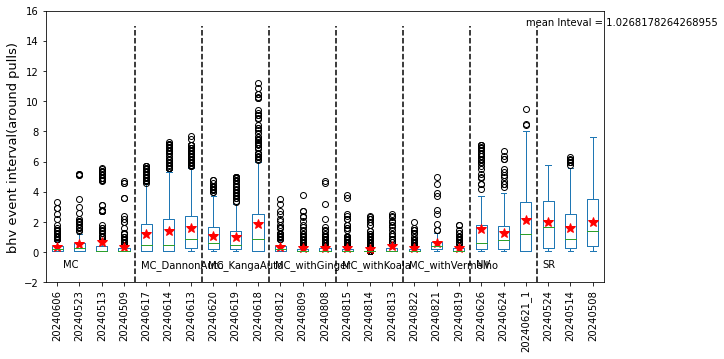

In [75]:
fig, ax1 = plt.subplots(figsize=(10, 5))
#
# sort the data based on task type and dates
sorting_df = pd.DataFrame({'dates': dates_list,'taskconditions': task_conditions}, 
                          columns=['dates', 'taskconditions','taskcondIDs'])
nIDs = np.shape(sorting_df)[0]
for iID in np.arange(0,nIDs,1):
    sorting_df.iloc[iID]['taskcondIDs'] = np.sum([ord(i) for i in sorting_df.iloc[iID]['taskconditions']])
#
sorting_df = sorting_df.sort_values(by=['taskconditions','dates'], ascending = [True,False])
dates_list_sorted = np.array(dates_list)[sorting_df.index]
ndates_sorted = np.shape(dates_list_sorted)[0]

pull_other_intv_forplots = {}
pull_other_intv_mean = np.zeros((1,ndates_sorted))[0]
pull_other_intv_ii = []
for ii in np.arange(0,ndates_sorted,1):
    pull_other_intv_ii = pd.Series(bhv_intv_all_dates[dates_list_sorted[ii]]['pull_other_pooled'])
    # remove the interval that is too large
    pull_other_intv_ii[pull_other_intv_ii>(np.nanmean(pull_other_intv_ii)+2*np.nanstd(pull_other_intv_ii))]= np.nan    
    # pull_other_intv_ii[pull_other_intv_ii>10]= np.nan
    pull_other_intv_forplots[ii] = pull_other_intv_ii
    pull_other_intv_mean[ii] = np.nanmean(pull_other_intv_ii)
    
    
#
pull_other_intv_forplots = pd.DataFrame(pull_other_intv_forplots)

#
# plot
pull_other_intv_forplots.plot(kind = 'box',ax=ax1, positions=np.arange(0,ndates_sorted,1))
# plt.boxplot(pull_other_intv_forplots)
plt.plot(np.arange(0,ndates_sorted,1),pull_other_intv_mean,'r*',markersize=10)
#
ax1.set_ylabel("bhv event interval(around pulls)",fontsize=13)
ax1.set_ylim([-2,16])
#
plt.xticks(np.arange(0,ndates_sorted,1),dates_list_sorted, rotation=90,fontsize=10)
plt.yticks(fontsize=10)
#
tasktypes = np.unique(sorting_df['taskconditions'])
taskswitches = np.where(np.array(sorting_df['taskcondIDs'])[1:]-np.array(sorting_df['taskcondIDs'])[:-1]!=0)[0]+0.5
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.plot([taskswitch,taskswitch],[-2,15],'k--')
taskswitches = np.concatenate(([0],taskswitches))
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.text(taskswitch+0.25,-1,tasktypes[itaskswitch],fontsize=10)
ax1.text(taskswitch-0.5,15,'mean Inteval = '+str(np.nanmean(pull_other_intv_forplots)),fontsize=10)

print(pull_other_intv_mean)
print(np.nanmean(pull_other_intv_forplots))

savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_neuron_bhv_singlecam_wholebodylabels_allsessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorders[0]+animal2_fixedorders[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"bhvInterval_hist_"+animal1_fixedorders[0]+animal2_fixedorders[0]+'.jpg')

### plot some other basis behavioral measures
#### successful rate

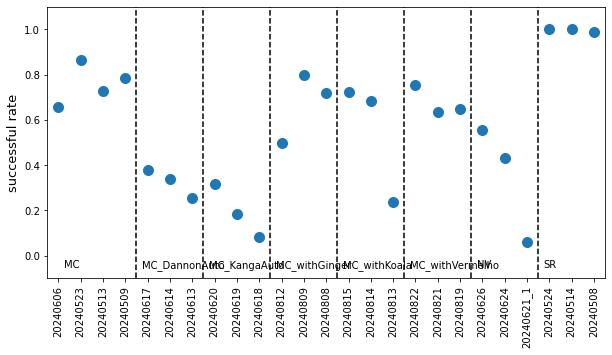

In [76]:
fig, ax1 = plt.subplots(figsize=(10, 5))
#
# sort the data based on task type and dates
sorting_df = pd.DataFrame({'dates': dates_list,'taskconditions': task_conditions}, 
                          columns=['dates', 'taskconditions','taskcondIDs'])
nIDs = np.shape(sorting_df)[0]
for iID in np.arange(0,nIDs,1):
    sorting_df.iloc[iID]['taskcondIDs'] = np.sum([ord(i) for i in sorting_df.iloc[iID]['taskconditions']])
#
sorting_df = sorting_df.sort_values(by=['taskconditions','dates'], ascending = [True,False])
dates_list_sorted = np.array(dates_list)[sorting_df.index]
ndates_sorted = np.shape(dates_list_sorted)[0]


ax1.plot(np.arange(0,ndates_sorted,1),succ_rate_all_dates[sorting_df.index],'o',markersize=10)
#
ax1.set_ylabel("successful rate",fontsize=13)
ax1.set_ylim([-0.1,1.1])
ax1.set_xlim([-0.5,ndates_sorted-0.5])
#
plt.xticks(np.arange(0,ndates_sorted,1),dates_list_sorted, rotation=90,fontsize=10)
plt.yticks(fontsize=10)
#
tasktypes = np.unique(sorting_df['taskconditions'])
taskswitches = np.where(np.array(sorting_df['taskcondIDs'])[1:]-np.array(sorting_df['taskcondIDs'])[:-1]!=0)[0]+0.5
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.plot([taskswitch,taskswitch],[-0.1,1.1],'k--')
taskswitches = np.concatenate(([0],taskswitches))
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.text(taskswitch+0.25,-0.05,tasktypes[itaskswitch],fontsize=10)
    
savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_neuron_bhv_singlecam_wholebodylabels_allsessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorders[0]+animal2_fixedorders[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"successfulrate_"+animal1_fixedorders[0]+animal2_fixedorders[0]+'.jpg')


#### animal pull numbers

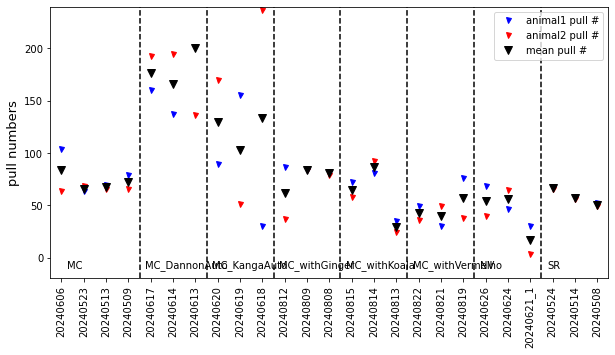

In [77]:
fig, ax1 = plt.subplots(figsize=(10, 5))
#
# sort the data based on task type and dates
sorting_df = pd.DataFrame({'dates': dates_list,'taskconditions': task_conditions}, 
                          columns=['dates', 'taskconditions','taskcondIDs'])
nIDs = np.shape(sorting_df)[0]
for iID in np.arange(0,nIDs,1):
    sorting_df.iloc[iID]['taskcondIDs'] = np.sum([ord(i) for i in sorting_df.iloc[iID]['taskconditions']])
#
sorting_df = sorting_df.sort_values(by=['taskconditions','dates'], ascending = [True,False])
dates_list_sorted = np.array(dates_list)[sorting_df.index]
ndates_sorted = np.shape(dates_list_sorted)[0]

pullmean_num_all_dates = (pull1_num_all_dates+pull2_num_all_dates)/2
ax1.plot(np.arange(0,ndates_sorted,1),pull1_num_all_dates[sorting_df.index],'bv',markersize=5,label='animal1 pull #')
ax1.plot(np.arange(0,ndates_sorted,1),pull2_num_all_dates[sorting_df.index],'rv',markersize=5,label='animal2 pull #')
ax1.plot(np.arange(0,ndates_sorted,1),pullmean_num_all_dates[sorting_df.index],'kv',markersize=8,label='mean pull #')
ax1.legend()


#
ax1.set_ylabel("pull numbers",fontsize=13)
ax1.set_ylim([-20,240])
ax1.set_xlim([-0.5,ndates_sorted-0.5])

#
plt.xticks(np.arange(0,ndates_sorted,1),dates_list_sorted, rotation=90,fontsize=10)
plt.yticks(fontsize=10)
#
tasktypes = np.unique(sorting_df['taskconditions'])
taskswitches = np.where(np.array(sorting_df['taskcondIDs'])[1:]-np.array(sorting_df['taskcondIDs'])[:-1]!=0)[0]+0.5
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.plot([taskswitch,taskswitch],[-20,240],'k--')
taskswitches = np.concatenate(([0],taskswitches))
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.text(taskswitch+0.25,-10,tasktypes[itaskswitch],fontsize=10)
    
savefigs = 0
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_neuron_bhv_singlecam_wholebodylabels_allsessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorders[0]+animal2_fixedorders[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"pullnumbers_"+animal1_fixedorders[0]+animal2_fixedorders[0]+'.jpg')


#### gaze number

In [78]:
gaze1_num_all_dates = owgaze1_num_all_dates + mtgaze1_num_all_dates
gaze2_num_all_dates = owgaze2_num_all_dates + mtgaze2_num_all_dates
gazemean_num_all_dates = (gaze1_num_all_dates+gaze2_num_all_dates)/2

print(np.nanmax(gaze1_num_all_dates))
print(np.nanmax(gaze2_num_all_dates))

1410.0
1998.0


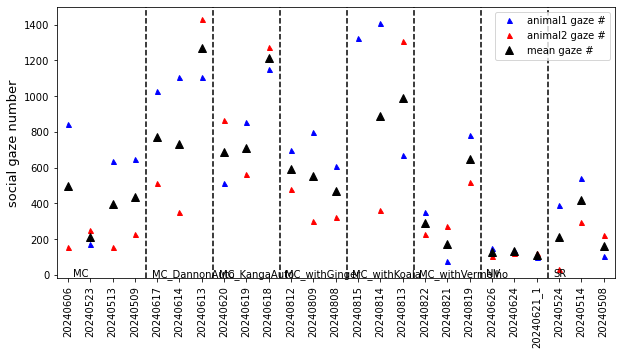

In [79]:
fig, ax1 = plt.subplots(figsize=(10, 5))
#
# sort the data based on task type and dates
sorting_df = pd.DataFrame({'dates': dates_list,'taskconditions': task_conditions}, 
                          columns=['dates', 'taskconditions','taskcondIDs'])
nIDs = np.shape(sorting_df)[0]
for iID in np.arange(0,nIDs,1):
    sorting_df.iloc[iID]['taskcondIDs'] = np.sum([ord(i) for i in sorting_df.iloc[iID]['taskconditions']])
#
sorting_df = sorting_df.sort_values(by=['taskconditions','dates'], ascending = [True,False])
dates_list_sorted = np.array(dates_list)[sorting_df.index]
ndates_sorted = np.shape(dates_list_sorted)[0]



ax1.plot(np.arange(0,ndates_sorted,1),gaze1_num_all_dates[sorting_df.index],'b^',markersize=5,label='animal1 gaze #')
ax1.plot(np.arange(0,ndates_sorted,1),gaze2_num_all_dates[sorting_df.index],'r^',markersize=5,label='animal2 gaze #')
ax1.plot(np.arange(0,ndates_sorted,1),gazemean_num_all_dates[sorting_df.index],'k^',markersize=8,label='mean gaze #')
ax1.legend()


#
ax1.set_ylabel("social gaze number",fontsize=13)
ax1.set_ylim([-20,1500])
ax1.set_xlim([-0.5,ndates_sorted-0.5])

#
plt.xticks(np.arange(0,ndates_sorted,1),dates_list_sorted, rotation=90,fontsize=10)
plt.yticks(fontsize=10)
#
tasktypes = np.unique(sorting_df['taskconditions'])
taskswitches = np.where(np.array(sorting_df['taskcondIDs'])[1:]-np.array(sorting_df['taskcondIDs'])[:-1]!=0)[0]+0.5
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.plot([taskswitch,taskswitch],[-20,1500],'k--')
taskswitches = np.concatenate(([0],taskswitches))
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.text(taskswitch+0.25,-10,tasktypes[itaskswitch],fontsize=10)
    
savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_neuron_bhv_singlecam_wholebodylabels_allsessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorders[0]+animal2_fixedorders[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"gazenumbers_"+animal1_fixedorders[0]+animal2_fixedorders[0]+'.jpg')


### prepare the input data for DBN
#### for both neural and behavioral events data

In [80]:
# define DBN related summarizing variables
DBN_input_data_alltypes = dict.fromkeys(dates_list, [])

doBhvitv_timebin = 0 # 1: if use the mean bhv event interval for time bin

prepare_input_data = 1

# DBN resolutions (make sure they are the same as in the later part of the code)

# temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
temp_resolus = [0.5] # temporal resolution in the DBN model, eg: 0.5 means 500ms
# temp_resolus = [0.2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
ntemp_reses = np.shape(temp_resolus)[0]

mergetempRos = 0

# # train the dynamic bayesian network - Alec's model 
#   prepare the multi-session table; one time lag; multi time steps (temporal resolution) as separate files

# prepare the DBN input data
if prepare_input_data:
    
    for idate in np.arange(0,ndates,1):
    # for idate in np.arange(0,1,1):
        
        date_tgt = dates_list[idate]
        videodate_tgt = videodates_list[idate]
        neural_record_condition = neural_record_conditions[idate]
        session_start_time = session_start_times[idate]
        kilosortver = kilosortvers[idate]
        task_condition = task_conditions[idate]
        
        animal1_filename = animal1_filenames[idate]
        animal2_filename = animal2_filenames[idate]
        
        animal1_fixedorder = [animal1_fixedorders[idate]]
        animal2_fixedorder = [animal2_fixedorders[idate]]
        

        # load behavioral results
        try:
            bhv_data_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
            trial_record_json = glob.glob(bhv_data_path +date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_TrialRecord_" + "*.json")
            bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_bhv_data_" + "*.json")
            session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_session_info_" + "*.json")
            ni_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_ni_data_" + "*.json")
            #
            trial_record = pd.read_json(trial_record_json[0])
            bhv_data = pd.read_json(bhv_data_json[0])
            session_info = pd.read_json(session_info_json[0])
            # 
            with open(ni_data_json[0]) as f:
                for line in f:
                    ni_data=json.loads(line)   
        except:
            bhv_data_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
            trial_record_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_TrialRecord_" + "*.json")
            bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_bhv_data_" + "*.json")
            session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_session_info_" + "*.json")
            ni_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_ni_data_" + "*.json")
            #
            trial_record = pd.read_json(trial_record_json[0])
            bhv_data = pd.read_json(bhv_data_json[0])
            session_info = pd.read_json(session_info_json[0])
            #
            with open(ni_data_json[0]) as f:
                for line in f:
                    ni_data=json.loads(line)

        # get animal info from the session information
        animal1 = session_info['lever1_animal'][0].lower()
        animal2 = session_info['lever2_animal'][0].lower()

        # clean up the trial_record
        warnings.filterwarnings('ignore')
        trial_record_clean = pd.DataFrame(columns=trial_record.columns)
        # for itrial in np.arange(0,np.max(trial_record['trial_number']),1):
        for itrial in trial_record['trial_number']:
            # trial_record_clean.loc[itrial] = trial_record[trial_record['trial_number']==itrial+1].iloc[[0]]
            trial_record_clean = trial_record_clean.append(trial_record[trial_record['trial_number']==itrial].iloc[[0]])
        trial_record_clean = trial_record_clean.reset_index(drop = True)

        # change bhv_data time to the absolute time
        time_points_new = pd.DataFrame(np.zeros(np.shape(bhv_data)[0]),columns=["time_points_new"])
        # for itrial in np.arange(0,np.max(trial_record_clean['trial_number']),1):
        for itrial in np.arange(0,np.shape(trial_record_clean)[0],1):
            # ind = bhv_data["trial_number"]==itrial+1
            ind = bhv_data["trial_number"]==trial_record_clean['trial_number'][itrial]
            new_time_itrial = bhv_data[ind]["time_points"] + trial_record_clean["trial_starttime"].iloc[itrial]
            time_points_new["time_points_new"][ind] = new_time_itrial
        bhv_data["time_points"] = time_points_new["time_points_new"]
        bhv_data = bhv_data[bhv_data["time_points"] != 0]

        
        # load behavioral event results
        print('load social gaze with '+cameraID+' only of '+date_tgt)
        with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'rb') as f:
            output_look_ornot = pickle.load(f)
        with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'rb') as f:
            output_allvectors = pickle.load(f)
        with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'rb') as f:
            output_allangles = pickle.load(f)  
        #
        look_at_other_or_not_merge = output_look_ornot['look_at_other_or_not_merge']
        look_at_tube_or_not_merge = output_look_ornot['look_at_tube_or_not_merge']
        look_at_lever_or_not_merge = output_look_ornot['look_at_lever_or_not_merge']
        # change the unit to second
        session_start_time = session_start_times[idate]
        look_at_other_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_other_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_lever_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_lever_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_tube_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_tube_or_not_merge['dodson'])[0],1)/fps - session_start_time 

        # find time point of behavioral events
        output_time_points_socialgaze ,output_time_points_levertube = bhv_events_timepoint_singlecam(bhv_data,look_at_other_or_not_merge,look_at_lever_or_not_merge,look_at_tube_or_not_merge)
        time_point_pull1 = output_time_points_socialgaze['time_point_pull1']
        time_point_pull2 = output_time_points_socialgaze['time_point_pull2']
        oneway_gaze1 = output_time_points_socialgaze['oneway_gaze1']
        oneway_gaze2 = output_time_points_socialgaze['oneway_gaze2']
        mutual_gaze1 = output_time_points_socialgaze['mutual_gaze1']
        mutual_gaze2 = output_time_points_socialgaze['mutual_gaze2'] 
        # 
        # mostly just for the sessions in which MC and SR are in the same session 
        firstpulltime = np.nanmin([np.nanmin(time_point_pull1),np.nanmin(time_point_pull2)])
        oneway_gaze1 = oneway_gaze1[oneway_gaze1>(firstpulltime-15)] # 15s before the first pull (animal1 or 2) count as the active period
        oneway_gaze2 = oneway_gaze2[oneway_gaze2>(firstpulltime-15)]
        mutual_gaze1 = mutual_gaze1[mutual_gaze1>(firstpulltime-15)]
        mutual_gaze2 = mutual_gaze2[mutual_gaze2>(firstpulltime-15)]  
        #    
        # newly added condition: only consider gaze during the active pulling time (15s after the last pull)    
        lastpulltime = np.nanmax([np.nanmax(time_point_pull1),np.nanmax(time_point_pull2)])
        oneway_gaze1 = oneway_gaze1[oneway_gaze1<(lastpulltime+15)]    
        oneway_gaze2 = oneway_gaze2[oneway_gaze2<(lastpulltime+15)]
        mutual_gaze1 = mutual_gaze1[mutual_gaze1<(lastpulltime+15)]
        mutual_gaze2 = mutual_gaze2[mutual_gaze2<(lastpulltime+15)] 
        
        
        # session starting time compared with the neural recording
        session_start_time_niboard_offset = ni_data['session_t0_offset'] # in the unit of second
        neural_start_time_niboard_offset = ni_data['trigger_ts'][0]['elapsed_time'] # in the unit of second
        neural_start_time_session_start_offset = neural_start_time_niboard_offset-session_start_time_niboard_offset
        
        # # load spike sorting results
        print('load spike data for '+neural_record_condition)
        if kilosortver == 2:
            spike_time_file = neural_data_folder+neural_record_condition+'/Kilosort/spike_times.npy'
            spike_time_data = np.load(spike_time_file)
        elif kilosortver == 4:
            spike_time_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/spike_times.npy'
            spike_time_data = np.load(spike_time_file)
        # 
        # align the FR recording time stamps
        spike_time_data = spike_time_data + fs_spikes*neural_start_time_session_start_offset
        #
        if kilosortver == 2:
            spike_clusters_file = neural_data_folder+neural_record_condition+'/Kilosort/spike_clusters.npy'
            spike_clusters_data = np.load(spike_clusters_file)
            spike_channels_data = np.copy(spike_clusters_data)
        elif kilosortver == 4:
            spike_clusters_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/spike_clusters.npy'
            spike_clusters_data = np.load(spike_clusters_file)
            spike_channels_data = np.copy(spike_clusters_data)
        #
        if kilosortver == 2:
            clusters_info_file = neural_data_folder+neural_record_condition+'/Kilosort/cluster_info.tsv'
            clusters_info_data = pd.read_csv(clusters_info_file,sep="\t")
        elif kilosortver == 4:
            clusters_info_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/cluster_info.tsv'
            clusters_info_data = pd.read_csv(clusters_info_file,sep="\t")
        #
        # only get the spikes that are manually checked
        try:
            good_clusters = clusters_info_data[(clusters_info_data.group=='good')|(clusters_info_data.group=='mua')]['cluster_id'].values
        except:
            good_clusters = clusters_info_data[(clusters_info_data.group=='good')|(clusters_info_data.group=='mua')]['id'].values
        #
        clusters_info_data = clusters_info_data[~pd.isnull(clusters_info_data.group)]
        #
        spike_time_data = spike_time_data[np.isin(spike_clusters_data,good_clusters)]
        spike_channels_data = spike_channels_data[np.isin(spike_clusters_data,good_clusters)]
        spike_clusters_data = spike_clusters_data[np.isin(spike_clusters_data,good_clusters)]
        #
        


        if mergetempRos:
            temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
            # use bhv event to decide temporal resolution
            #
            #low_lim,up_lim,_ = bhv_events_interval(totalsess_time, session_start_time, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
            #temp_resolus = temp_resolus = np.arange(low_lim,up_lim,0.1)
        #
        if doBhvitv_timebin:
            pull_other_intv_ii = pd.Series(bhv_intv_all_dates[date_tgt]['pull_other_pooled'])
            # remove the interval that is too large
            pull_other_intv_ii[pull_other_intv_ii>(np.nanmean(pull_other_intv_ii)+2*np.nanstd(pull_other_intv_ii))]= np.nan    
            # pull_other_intv_ii[pull_other_intv_ii>10]= np.nan
            temp_resolus = [np.nanmean(pull_other_intv_ii)]          
        #
        ntemp_reses = np.shape(temp_resolus)[0]           

        
        # try different temporal resolutions
        for temp_resolu in temp_resolus:
            
            # down-sample the spike recording resolution to match the temp_resolus
            spike_time_data = spike_time_data/fs_spikes*(1/temp_resolu)
            spike_time_data = np.round(spike_time_data)/(1/temp_resolu)
            spike_time_point = spike_time_data
            
            bhv_df = []

            if np.isin(animal1,animal1_fixedorder):
                bhv_df_itr,_,_ = train_DBN_multiLag_create_df_only(lastpulltime+20, firstpulltime-20, temp_resolu, spike_time_point, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
            else:
                bhv_df_itr,_,_ = train_DBN_multiLag_create_df_only(lastpulltime+20, firstpulltime-20, temp_resolu, spike_time_point, time_point_pull2, time_point_pull1, oneway_gaze2, oneway_gaze1, mutual_gaze2, mutual_gaze1)     

            if len(bhv_df)==0:
                bhv_df = bhv_df_itr
            else:
                bhv_df = pd.concat([bhv_df,bhv_df_itr])                   
                bhv_df = bhv_df.reset_index(drop=True)        

            DBN_input_data_alltypes[date_tgt] = bhv_df
            
    # save data
    if 1:
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_withNeuron_allsessions'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
        if not os.path.exists(data_saved_subfolder):
            os.makedirs(data_saved_subfolder)
        if not mergetempRos:
            if doBhvitv_timebin:
                with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'bhvItvTempReSo.pkl', 'wb') as f:
                    pickle.dump(DBN_input_data_alltypes, f)
            else:
                with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'sReSo.pkl', 'wb') as f:
                    pickle.dump(DBN_input_data_alltypes, f)
        else:
            with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_mergeTempsReSo.pkl', 'wb') as f:
                pickle.dump(DBN_input_data_alltypes, f)     

load social gaze with camera-2 only of 20240508
load spike data for 20240508_Kanga_SR
load social gaze with camera-2 only of 20240509
load spike data for 20240509_Kanga_MC
load social gaze with camera-2 only of 20240513
load spike data for 20240513_Kanga_MC
load social gaze with camera-2 only of 20240514
load spike data for 20240514_Kanga_SR
load social gaze with camera-2 only of 20240523
load spike data for 20240523_Kanga_MC
load social gaze with camera-2 only of 20240524
load spike data for 20240524_Kanga_SR
load social gaze with camera-2 only of 20240606
load spike data for 20240606_Kanga_MC
load social gaze with camera-2 only of 20240613
load spike data for 20240613_Kanga_MC_DannonAuto
load social gaze with camera-2 only of 20240614
load spike data for 20240614_Kanga_MC_DannonAuto
load social gaze with camera-2 only of 20240617
load spike data for 20240617_Kanga_MC_DannonAuto
load social gaze with camera-2 only of 20240618
load spike data for 20240618_Kanga_MC_KangaAuto
load social

### run the DBN model on the combined session data set

#### a test run

In [ ]:
# run DBN on the large table with merged sessions

mergetempRos = 0 # 1: merge different time bins

minmaxfullSampSize = 1 # 1: use the  min row number and max row number, or the full row for each session

moreSampSize = 0 # 1: use more sample size (more than just minimal row number and max row number)

num_starting_points = 1 # number of random starting points/graphs
nbootstraps = 1

if 0:

    if moreSampSize:
        # different data (down/re)sampling numbers
        samplingsizes = np.arange(1100,3000,100)
        # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
        # samplingsizes = [100,500]
        # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
        samplingsizes_name = list(map(str, samplingsizes))
        nsamplings = np.shape(samplingsizes)[0]

    weighted_graphs_diffTempRo_diffSampSize = {}
    weighted_graphs_shuffled_diffTempRo_diffSampSize = {}
    sig_edges_diffTempRo_diffSampSize = {}
    DAGscores_diffTempRo_diffSampSize = {}
    DAGscores_shuffled_diffTempRo_diffSampSize = {}

    totalsess_time = 600 # total session time in s
    # temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    temp_resolus = [0.5] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    # temp_resolus = [0.2]
    ntemp_reses = np.shape(temp_resolus)[0]

    # try different temporal resolutions, remember to use the same settings as in the previous ones
    for temp_resolu in temp_resolus:

        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_withNeuron_allsessions'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
        if not mergetempRos:
            if doBhvitv_timebin:
                with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'bhvItvTempReSo.pkl', 'rb') as f:
                    DBN_input_data_alltypes = pickle.load(f)
            else:
                with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
                    DBN_input_data_alltypes = pickle.load(f)
        else:
            with open(data_saved_subfolder+'//DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_mergeTempsReSo.pkl', 'rb') as f:
                DBN_input_data_alltypes = pickle.load(f)

                
        # only try three sample sizes
        #- minimal row number (require data downsample) and maximal row number (require data upsample)
        #- full row number of each session
        if minmaxfullSampSize:
            key_to_value_lengths = {k:len(v) for k, v in DBN_input_data_alltypes.items()}
            key_to_value_lengths_array = np.fromiter(key_to_value_lengths.values(),dtype=float)
            key_to_value_lengths_array[key_to_value_lengths_array==0]=np.nan
            min_samplesize = np.nanmin(key_to_value_lengths_array)
            min_samplesize = int(min_samplesize/100)*100
            max_samplesize = np.nanmax(key_to_value_lengths_array)
            max_samplesize = int(max_samplesize/100)*100
            #samplingsizes = [min_samplesize,max_samplesize,np.nan]
            #samplingsizes_name = ['min_row_number','max_row_number','full_row_number']
            samplingsizes = [np.nan]
            samplingsizes_name = ['full_row_number']
            nsamplings = np.shape(samplingsizes)[0]
            print(samplingsizes)
                
        # try different down/re-sampling size
        # for jj in np.arange(0,nsamplings,1):
        for jj in np.arange(0,1,1):
            
            isamplingsize = samplingsizes[jj]
            
            DAGs_alltypes = dict.fromkeys(dates_list, [])
            DAGs_shuffle_alltypes = dict.fromkeys(dates_list, [])
            DAGs_scores_alltypes = dict.fromkeys(dates_list, [])
            DAGs_shuffle_scores_alltypes = dict.fromkeys(dates_list, [])

            weighted_graphs_alltypes = dict.fromkeys(dates_list, [])
            weighted_graphs_shuffled_alltypes = dict.fromkeys(dates_list, [])
            sig_edges_alltypes = dict.fromkeys(dates_list, [])

            # different individual sessions
            ndates = np.shape(dates_list)[0]
            for idate in np.arange(0,ndates,1):
                date_tgt = dates_list[idate]
                
                if samplingsizes_name[jj]=='full_row_number':
                    isamplingsize = np.shape(DBN_input_data_alltypes[date_tgt])[0]

                try:
                    bhv_df_all = DBN_input_data_alltypes[date_tgt]

                    # define DBN graph structures; make sure they are the same as in the train_DBN_multiLag
                    colnames = list(bhv_df_all.columns)
                    eventnames = ["pull1","pull2","owgaze1","owgaze2","spikes"]
                    nevents = np.size(eventnames)

                    all_pops = list(bhv_df_all.columns)
                    from_pops = [pop for pop in all_pops if not pop.endswith('t3')]
                    to_pops = [pop for pop in all_pops if pop.endswith('t3')]
                    causal_whitelist = [(from_pop,to_pop) for from_pop in from_pops for to_pop in to_pops]

                    nFromNodes = np.shape(from_pops)[0]
                    nToNodes = np.shape(to_pops)[0]

                    DAGs_randstart = np.zeros((num_starting_points, nFromNodes, nToNodes))
                    DAGs_randstart_shuffle = np.zeros((num_starting_points, nFromNodes, nToNodes))
                    score_randstart = np.zeros((num_starting_points))
                    score_randstart_shuffle = np.zeros((num_starting_points))

                    # step 1: randomize the starting point for num_starting_points times
                    for istarting_points in np.arange(0,num_starting_points,1):

                        # try different down/re-sampling size
                        bhv_df = bhv_df_all.sample(isamplingsize,replace = True, random_state = istarting_points) # take the subset for DBN training
                        aic = AicScore(bhv_df)

                        #Anirban(Alec) shuffle, slow
                        bhv_df_shuffle, df_shufflekeys = EfficientShuffle(bhv_df,round(time()))
                        aic_shuffle = AicScore(bhv_df_shuffle)

                        np.random.seed(istarting_points)
                        random.seed(istarting_points)
                        starting_edges = random.sample(causal_whitelist, np.random.randint(1,len(causal_whitelist)))
                        starting_graph = DAG()
                        starting_graph.add_nodes_from(nodes=all_pops)
                        starting_graph.add_edges_from(ebunch=starting_edges)

                        best_model,edges,DAGs = train_DBN_multiLag_training_only(bhv_df,starting_graph,colnames,eventnames,from_pops,to_pops)           
                        DAGs[0][np.isnan(DAGs[0])]=0

                        DAGs_randstart[istarting_points,:,:] = DAGs[0]
                        score_randstart[istarting_points] = aic.score(best_model)

                        # step 2: add the shffled data results
                        # shuffled bhv_df
                        best_model,edges,DAGs = train_DBN_multiLag_training_only(bhv_df_shuffle,starting_graph,colnames,eventnames,from_pops,to_pops)           
                        DAGs[0][np.isnan(DAGs[0])]=0

                        DAGs_randstart_shuffle[istarting_points,:,:] = DAGs[0]
                        score_randstart_shuffle[istarting_points] = aic_shuffle.score(best_model)

                    DAGs_alltypes[date_tgt] = DAGs_randstart 
                    DAGs_shuffle_alltypes[date_tgt] = DAGs_randstart_shuffle

                    DAGs_scores_alltypes[date_tgt] = score_randstart
                    DAGs_shuffle_scores_alltypes[date_tgt] = score_randstart_shuffle

                    weighted_graphs = get_weighted_dags(DAGs_alltypes[date_tgt],nbootstraps)
                    weighted_graphs_shuffled = get_weighted_dags(DAGs_shuffle_alltypes[date_tgt],nbootstraps)
                    sig_edges = get_significant_edges(weighted_graphs,weighted_graphs_shuffled)

                    weighted_graphs_alltypes[date_tgt] = weighted_graphs
                    weighted_graphs_shuffled_alltypes[date_tgt] = weighted_graphs_shuffled
                    sig_edges_alltypes[date_tgt] = sig_edges
                    
                except:
                    DAGs_alltypes[date_tgt] = [] 
                    DAGs_shuffle_alltypes[date_tgt] = []

                    DAGs_scores_alltypes[date_tgt] = []
                    DAGs_shuffle_scores_alltypes[date_tgt] = []

                    weighted_graphs_alltypes[date_tgt] = []
                    weighted_graphs_shuffled_alltypes[date_tgt] = []
                    sig_edges_alltypes[date_tgt] = []
                
            DAGscores_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = DAGs_scores_alltypes
            DAGscores_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = DAGs_shuffle_scores_alltypes

            weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = weighted_graphs_alltypes
            weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = weighted_graphs_shuffled_alltypes
            sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = sig_edges_alltypes

    print(weighted_graphs_diffTempRo_diffSampSize)
            
   

#### run on the entire population

In [ ]:
# run DBN on the large table with merged sessions

mergetempRos = 0 # 1: merge different time bins

minmaxfullSampSize = 1 # 1: use the  min row number and max row number, or the full row for each session

moreSampSize = 0 # 1: use more sample size (more than just minimal row number and max row number)

num_starting_points = 100 # number of random starting points/graphs
nbootstraps = 95

totalsess_time = 600 # total session time in s
# temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
temp_resolus = [0.5] # temporal resolution in the DBN model, eg: 0.5 means 500ms
# temp_resolus = [0.2]
ntemp_reses = np.shape(temp_resolus)[0]
        
# different individual sessions
ndates = np.shape(dates_list)[0]
for idate in np.arange(0,ndates,1):
    date_tgt = dates_list[idate]
     
    # try different temporal resolutions, remember to use the same settings as in the previous ones
    for temp_resolu in temp_resolus:

        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_withNeuron_allsessions'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
        if not mergetempRos:
            if doBhvitv_timebin:
                with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'bhvItvTempReSo.pkl', 'rb') as f:
                    DBN_input_data_alltypes = pickle.load(f)
            else:
                with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
                    DBN_input_data_alltypes = pickle.load(f)
        else:
            with open(data_saved_subfolder+'//DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_mergeTempsReSo.pkl', 'rb') as f:
                DBN_input_data_alltypes = pickle.load(f)
    
    
        try:
            # dumpy
            print('load DBN result for '+date_tgt+'_'+str(temp_resolu))
            savedata = 0
            
            data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_withNeuron_allsessions'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'+date_tgt+'/'
            if not os.path.exists(data_saved_subfolder):
                os.makedirs(data_saved_subfolder)
            if moreSampSize:
                with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
                    DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
                with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
                    DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
                with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
                    weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
                with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
                    weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
                with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
                    sig_edges_diffTempRo_diffSampSize = pickle.load(f)

            if minmaxfullSampSize:
                with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
                    DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
                with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
                    DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
                with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
                    weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
                with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
                    weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
                with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
                    sig_edges_diffTempRo_diffSampSize = pickle.load(f)

        except:
            print('analyze DBN result for '+date_tgt+'_'+str(temp_resolu))
            savedata = 1
            
            if moreSampSize:
                # different data (down/re)sampling numbers
                samplingsizes = np.arange(1100,3000,100)
                # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
                # samplingsizes = [100,500]
                # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
                samplingsizes_name = list(map(str, samplingsizes))
                nsamplings = np.shape(samplingsizes)[0]

            weighted_graphs_diffTempRo_diffSampSize = {}
            weighted_graphs_shuffled_diffTempRo_diffSampSize = {}
            sig_edges_diffTempRo_diffSampSize = {}
            DAGscores_diffTempRo_diffSampSize = {}
            DAGscores_shuffled_diffTempRo_diffSampSize = {}


            # only try three sample sizes
            #- minimal row number (require data downsample) and maximal row number (require data upsample)
            #- full row number of each session
            if minmaxfullSampSize:
                key_to_value_lengths = {k:len(v) for k, v in DBN_input_data_alltypes.items()}
                key_to_value_lengths_array = np.fromiter(key_to_value_lengths.values(),dtype=float)
                key_to_value_lengths_array[key_to_value_lengths_array==0]=np.nan
                min_samplesize = np.nanmin(key_to_value_lengths_array)
                min_samplesize = int(min_samplesize/100)*100
                max_samplesize = np.nanmax(key_to_value_lengths_array)
                max_samplesize = int(max_samplesize/100)*100
                # samplingsizes = [min_samplesize,max_samplesize,np.nan]
                # samplingsizes_name = ['min_row_number','max_row_number','full_row_number']   
                samplingsizes = [np.nan]
                samplingsizes_name = ['full_row_number']
                nsamplings = np.shape(samplingsizes)[0]
                print(samplingsizes)

            # try different down/re-sampling size
            for jj in np.arange(0,nsamplings,1):

                isamplingsize = samplingsizes[jj]

                DAGs_alltypes = dict.fromkeys(dates_list, [])
                DAGs_shuffle_alltypes = dict.fromkeys(dates_list, [])
                DAGs_scores_alltypes = dict.fromkeys(dates_list, [])
                DAGs_shuffle_scores_alltypes = dict.fromkeys(dates_list, [])

                weighted_graphs_alltypes = dict.fromkeys(dates_list, [])
                weighted_graphs_shuffled_alltypes = dict.fromkeys(dates_list, [])
                sig_edges_alltypes = dict.fromkeys(dates_list, [])

            
                
                if samplingsizes_name[jj]=='full_row_number':
                    isamplingsize = np.shape(DBN_input_data_alltypes[date_tgt])[0]

                try:
                    bhv_df_all = DBN_input_data_alltypes[date_tgt]


                    # define DBN graph structures; make sure they are the same as in the train_DBN_multiLag
                    colnames = list(bhv_df_all.columns)
                    eventnames = ["pull1","pull2","owgaze1","owgaze2","spikes"]
                    nevents = np.size(eventnames)

                    all_pops = list(bhv_df_all.columns)
                    from_pops = [pop for pop in all_pops if not pop.endswith('t3')]
                    to_pops = [pop for pop in all_pops if pop.endswith('t3')]
                    causal_whitelist = [(from_pop,to_pop) for from_pop in from_pops for to_pop in to_pops]

                    nFromNodes = np.shape(from_pops)[0]
                    nToNodes = np.shape(to_pops)[0]

                    DAGs_randstart = np.zeros((num_starting_points, nFromNodes, nToNodes))
                    DAGs_randstart_shuffle = np.zeros((num_starting_points, nFromNodes, nToNodes))
                    score_randstart = np.zeros((num_starting_points))
                    score_randstart_shuffle = np.zeros((num_starting_points))

                    # step 1: randomize the starting point for num_starting_points times
                    for istarting_points in np.arange(0,num_starting_points,1):

                        # try different down/re-sampling size
                        bhv_df = bhv_df_all.sample(isamplingsize,replace = True, random_state = istarting_points) # take the subset for DBN training
                        aic = AicScore(bhv_df)

                        #Anirban(Alec) shuffle, slow
                        bhv_df_shuffle, df_shufflekeys = EfficientShuffle(bhv_df,round(time()))
                        aic_shuffle = AicScore(bhv_df_shuffle)

                        np.random.seed(istarting_points)
                        random.seed(istarting_points)
                        starting_edges = random.sample(causal_whitelist, np.random.randint(1,len(causal_whitelist)))
                        starting_graph = DAG()
                        starting_graph.add_nodes_from(nodes=all_pops)
                        starting_graph.add_edges_from(ebunch=starting_edges)

                        best_model,edges,DAGs = train_DBN_multiLag_training_only(bhv_df,starting_graph,colnames,eventnames,from_pops,to_pops)           
                        DAGs[0][np.isnan(DAGs[0])]=0

                        DAGs_randstart[istarting_points,:,:] = DAGs[0]
                        score_randstart[istarting_points] = aic.score(best_model)

                        # step 2: add the shffled data results
                        # shuffled bhv_df
                        best_model,edges,DAGs = train_DBN_multiLag_training_only(bhv_df_shuffle,starting_graph,colnames,eventnames,from_pops,to_pops)           
                        DAGs[0][np.isnan(DAGs[0])]=0

                        DAGs_randstart_shuffle[istarting_points,:,:] = DAGs[0]
                        score_randstart_shuffle[istarting_points] = aic_shuffle.score(best_model)

                    DAGs_alltypes[date_tgt] = DAGs_randstart 
                    DAGs_shuffle_alltypes[date_tgt] = DAGs_randstart_shuffle

                    DAGs_scores_alltypes[date_tgt] = score_randstart
                    DAGs_shuffle_scores_alltypes[date_tgt] = score_randstart_shuffle

                    weighted_graphs = get_weighted_dags(DAGs_alltypes[date_tgt],nbootstraps)
                    weighted_graphs_shuffled = get_weighted_dags(DAGs_shuffle_alltypes[date_tgt],nbootstraps)
                    sig_edges = get_significant_edges(weighted_graphs,weighted_graphs_shuffled)

                    weighted_graphs_alltypes[date_tgt] = weighted_graphs
                    weighted_graphs_shuffled_alltypes[date_tgt] = weighted_graphs_shuffled
                    sig_edges_alltypes[date_tgt] = sig_edges
                    
                except:
                    DAGs_alltypes[date_tgt] = [] 
                    DAGs_shuffle_alltypes[date_tgt] = []

                    DAGs_scores_alltypes[date_tgt] = []
                    DAGs_shuffle_scores_alltypes[date_tgt] = []

                    weighted_graphs_alltypes[date_tgt] = []
                    weighted_graphs_shuffled_alltypes[date_tgt] = []
                    sig_edges_alltypes[date_tgt] = []
                
            DAGscores_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = DAGs_scores_alltypes
            DAGscores_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = DAGs_shuffle_scores_alltypes

            weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = weighted_graphs_alltypes
            weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = weighted_graphs_shuffled_alltypes
            sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = sig_edges_alltypes

            
        # save data
        if savedata:
            print('save DBN result for '+date_tgt+'_'+str(temp_resolu))

            data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_withNeuron_allsessions'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'+date_tgt+'/'
            if not os.path.exists(data_saved_subfolder):
                os.makedirs(data_saved_subfolder)
            if moreSampSize:  
                with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'wb') as f:
                    pickle.dump(DAGscores_diffTempRo_diffSampSize, f)
                with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'wb') as f:
                    pickle.dump(DAGscores_shuffled_diffTempRo_diffSampSize, f)
                with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'wb') as f:
                    pickle.dump(weighted_graphs_diffTempRo_diffSampSize, f)
                with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'wb') as f:
                    pickle.dump(weighted_graphs_shuffled_diffTempRo_diffSampSize, f)
                with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'wb') as f:
                    pickle.dump(sig_edges_diffTempRo_diffSampSize, f)
            elif minmaxfullSampSize:
                with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'wb') as f:
                    pickle.dump(DAGscores_diffTempRo_diffSampSize, f)
                with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'wb') as f:
                    pickle.dump(DAGscores_shuffled_diffTempRo_diffSampSize, f)
                with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'wb') as f:
                    pickle.dump(weighted_graphs_diffTempRo_diffSampSize, f)
                with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'wb') as f:
                    pickle.dump(weighted_graphs_shuffled_diffTempRo_diffSampSize, f)
                with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'wb') as f:
                    pickle.dump(sig_edges_diffTempRo_diffSampSize, f)        
            else:
                with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'wb') as f:
                    pickle.dump(DAGscores_diffTempRo_diffSampSize, f)
                with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'wb') as f:
                    pickle.dump(DAGscores_shuffled_diffTempRo_diffSampSize, f)
                with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'wb') as f:
                    pickle.dump(weighted_graphs_diffTempRo_diffSampSize, f)
                with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'wb') as f:
                    pickle.dump(weighted_graphs_shuffled_diffTempRo_diffSampSize, f)
                with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'wb') as f:
                    pickle.dump(sig_edges_diffTempRo_diffSampSize, f)


### plot graphs - show the edge with arrows; show the best time bin and row number; show the three time lag separately

In [ ]:
dates_list_plot = ["20231101_SR","20231101_MC",]
ndates_plot = np.shape(dates_list_plot)[0]

In [ ]:

# make sure these variables are the same as in the previous steps
# temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
temp_resolus = [0.5] # temporal resolution in the DBN model, eg: 0.5 means 500ms
# temp_resolus = [0.2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
ntemp_reses = np.shape(temp_resolus)[0]
#
if moreSampSize:
    # different data (down/re)sampling numbers
    # samplingsizes = np.arange(1100,3000,100)
    samplingsizes = [1100]
    # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
    # samplingsizes = [100,500]
    # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
    samplingsizes_name = list(map(str, samplingsizes))
else:
    samplingsizes_name = ['full_row_number']   
nsamplings = np.shape(samplingsizes_name)[0]

# make sure these variables are consistent with the train_DBN_alec.py settings
eventnames = ["pull1","pull2","gaze1","gaze2",'OFCspikes']
eventnode_locations = [[0,1],[1,1],[0,0],[1,0],[-0.5,0.5],]
eventname_locations = [[0,1],[1,1],[0,0],[1,0],[-0.5,0.5],]
# indicate where edge starts
# for the self edge, it's the center of the self loop
nodearrow_locations = [[[0.00,1.25],[0.25,1.10],[-.10,0.75],[0.15,0.65],[-0.15,1.0],[0.15,0.75]],
                       [[0.75,1.00],[1.00,1.25],[0.85,0.65],[1.10,0.75],[0.85,0.75],[1.15,1.00]],
                       [[0.00,0.25],[0.25,0.35],[0.00,-.25],[0.25,-.10],[-0.15,-.05],[0.15,0.00]],
                       [[0.75,0.35],[1.00,0.25],[0.75,0.00],[1.00,-.25],[0.85,0.00],[1.15,-.05]],
                       [[-0.35,.65],[-0.25,.65],[-0.35,.25],[-0.35,.35],[-0.65,.50],[-0.2,0.45]],
                       ]
# indicate where edge goes
# for the self edge, it's the theta1 and theta2 (with fixed radius)
nodearrow_directions = [[[ -45,-180],[0.50,0.00],[0.00,-.50],[0.50,-.50],[-0.2,-0.2],[1.00,-0.2]],
                        [[-.50,0.00],[ -45,-180],[-.50,-.50],[0.00,-.50],[-1.0,-0.2],[0.20,-0.2]],
                        [[0.00,0.50],[0.50,0.50],[ 180,  45],[0.50,0.00],[-0.2,0.20],[1.00,0.20]],
                        [[-.50,0.50],[0.00,0.50],[-.50,0.00],[ 180,  45],[-1.0,0.20],[0.20,0.20]],
                        [[0.20,0.20],[1.10,0.20],[0.20,-.20],[1.10,-.20],[  45, -90],[1.25,0.00]],
                       ]

nevents = np.size(eventnames)
eventnodes_color = ['#BF3EFF','#FF7F00','#BF3EFF','#FF7F00','#BF3EFF',]
eventnodes_shape = ["o","o","^","^","*",]
    

# different session conditions (aka DBN groups)
# different time lags (t_-3, t_-2 and t_-1)
fig, axs = plt.subplots(6,ndates_plot)
fig.set_figheight(48)
fig.set_figwidth(8*ndates_plot)

time_lags = ['t_-1.5','t_-1','t_-0.5']
# time_lags = ['t_-0.6','t_-0.4','t_-0.2']
# fromRowIDs =[[0,1,2,3],[6,7,8,9],[12,13,14,15]]
# toColID = [0,1,2,3]
fromRowIDs =[[0,1,2,3,4,],[5,6,7,8,9,],[10,11,12,13,14,]]
toColID = [0,1,2,3,4,]
ntime_lags = np.shape(time_lags)[0]

temp_resolu = temp_resolus[0]
j_sampsize_name = samplingsizes_name[0]    

for ilag in np.arange(0,ntime_lags,1):
    
    time_lag_name = time_lags[ilag]
    fromRowID = fromRowIDs[ilag]
    
    for idate in np.arange(0,ndates_plot,1):

        # try:

            idate_typename = dates_list_plot[idate]

            # load data accordingly
            data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_withNeuron_allsessions'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'+idate_typename+'/'
            #
            if moreSampSize:
                with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
                    DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
                with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
                    DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
                with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
                    weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
                with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
                    weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
                with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
                    sig_edges_diffTempRo_diffSampSize = pickle.load(f)
            elif minmaxfullSampSize:
                with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
                    DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
                with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
                    DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
                with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
                    weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
                with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
                    weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
                with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
                    sig_edges_diffTempRo_diffSampSize = pickle.load(f)
            else:
                with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
                    DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
                with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
                    DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
                with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
                    weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
                with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
                    weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
                with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
                    sig_edges_diffTempRo_diffSampSize = pickle.load(f)


            weighted_graphs_tgt = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][idate_typename]
            weighted_graphs_shuffled_tgt = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][idate_typename]
            # sig_edges_tgt = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][idate_typename]
            sig_edges_tgt = get_significant_edges(weighted_graphs_tgt,weighted_graphs_shuffled_tgt)

            #sig_edges_tgt = sig_edges_tgt*((weighted_graphs_tgt.mean(axis=0)>0.5)*1)

            sig_avg_dags = weighted_graphs_tgt.mean(axis = 0) * sig_edges_tgt
            sig_avg_dags = sig_avg_dags[fromRowID,:]
            sig_avg_dags = sig_avg_dags[:,toColID]

            # plot
            axs[ilag*2+0,idate].set_title(idate_typename,fontsize=14)
            axs[ilag*2+0,idate].set_xlim([-0.5,1.5])
            axs[ilag*2+0,idate].set_ylim([-0.5,1.5])
            axs[ilag*2+0,idate].set_xticks([])
            axs[ilag*2+0,idate].set_xticklabels([])
            axs[ilag*2+0,idate].set_yticks([])
            axs[ilag*2+0,idate].set_yticklabels([])
            axs[ilag*2+0,idate].spines['top'].set_visible(False)
            axs[ilag*2+0,idate].spines['right'].set_visible(False)
            axs[ilag*2+0,idate].spines['bottom'].set_visible(False)
            axs[ilag*2+0,idate].spines['left'].set_visible(False)
            # axs[ilag*2+0,idate].axis('equal')


            for ieventnode in np.arange(0,nevents,1):
                # plot the event nodes
                axs[ilag*2+0,idate].plot(eventnode_locations[ieventnode][0],eventnode_locations[ieventnode][1],
                                              eventnodes_shape[ieventnode],markersize=40,markerfacecolor=eventnodes_color[ieventnode],
                                              markeredgecolor='none')              
                axs[ilag*2+0,idate].text(eventname_locations[ieventnode][0],eventname_locations[ieventnode][1],
                                       eventnames[ieventnode],fontsize=15)

                clmap = mpl.cm.get_cmap('Greens')

                # plot the event edges
                for ifromNode in np.arange(0,nevents,1):
                    for itoNode in np.arange(0,nevents,1):
                        edge_weight_tgt = sig_avg_dags[ifromNode,itoNode]
                        if edge_weight_tgt>0:
                            if not ifromNode == itoNode:
                                #axs[ilag*2+0,idate].plot(eventnode_locations[ifromNode],eventnode_locations[itoNode],'k-',linewidth=edge_weight_tgt*3)
                                axs[ilag*2+0,idate].arrow(nodearrow_locations[ifromNode][itoNode][0],
                                                        nodearrow_locations[ifromNode][itoNode][1],
                                                        nodearrow_directions[ifromNode][itoNode][0],
                                                        nodearrow_directions[ifromNode][itoNode][1],
                                                        # head_width=0.08*abs(edge_weight_tgt),
                                                        # width=0.04*abs(edge_weight_tgt),
                                                        head_width=0.08,
                                                        width=0.04,   
                                                        color = clmap(edge_weight_tgt))
                            if ifromNode == itoNode:
                                ring = mpatches.Wedge(nodearrow_locations[ifromNode][itoNode],
                                                      .1, nodearrow_directions[ifromNode][itoNode][0],
                                                      nodearrow_directions[ifromNode][itoNode][1], 
                                                      # 0.04*abs(edge_weight_tgt),
                                                      0.04,
                                                      color = clmap(edge_weight_tgt))
                                p = PatchCollection(
                                    [ring], 
                                    facecolor=clmap(edge_weight_tgt), 
                                    edgecolor=clmap(edge_weight_tgt)
                                )
                                axs[ilag*2+0,idate].add_collection(p)
                                # add arrow head
                                if ifromNode < 2:
                                    axs[ilag*2+0,idate].arrow(nodearrow_locations[ifromNode][itoNode][0]-0.1+0.02*edge_weight_tgt,
                                                            nodearrow_locations[ifromNode][itoNode][1],
                                                            0,-0.05,color=clmap(edge_weight_tgt),
                                                            # head_width=0.08*edge_weight_tgt,width=0.04*edge_weight_tgt
                                                            head_width=0.08,width=0.04      
                                                            )
                                elif ifromNode < 4:
                                    axs[ilag*2+0,idate].arrow(nodearrow_locations[ifromNode][itoNode][0]-0.1+0.02*edge_weight_tgt,
                                                            nodearrow_locations[ifromNode][itoNode][1],
                                                            0,0.02,color=clmap(edge_weight_tgt),
                                                            # head_width=0.08*edge_weight_tgt,width=0.04*edge_weight_tgt
                                                            head_width=0.08,width=0.04      
                                                            )

            # heatmap for the weights
            sig_avg_dags_df = pd.DataFrame(sig_avg_dags)
            sig_avg_dags_df.columns = eventnames
            sig_avg_dags_df.index = eventnames
            vmin,vmax = 0,1
            import matplotlib as mpl
            norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
            im = axs[ilag*2+1,idate].pcolormesh(sig_avg_dags_df,cmap="Greens",norm=norm)
            #
            if idate == ndates_plot-1:
                cax = axs[ilag*2+1,idate].inset_axes([1.04, 0.2, 0.05, 0.8])
                fig.colorbar(im, ax=axs[ilag*2+1,idate], cax=cax,label='edge confidence')

            axs[ilag*2+1,idate].axis('equal')
            axs[ilag*2+1,idate].set_xlabel('to Node',fontsize=14)
            axs[ilag*2+1,idate].set_xticks(np.arange(0.5,5.5,1))
            axs[ilag*2+1,idate].set_xticklabels(eventnames)
            if idate == 0:
                axs[ilag*2+1,idate].set_ylabel('from Node',fontsize=14)
                axs[ilag*2+1,idate].set_yticks(np.arange(0.5,5.5,1))
                axs[ilag*2+1,idate].set_yticklabels(eventnames)
                axs[ilag*2+1,idate].text(-1.5,1,time_lag_name+' time lag',rotation=90,fontsize=20)
                axs[ilag*2+0,idate].text(-1.25,0,time_lag_name+' time lag',rotation=90,fontsize=20)
            else:
                axs[ilag*2+1,idate].set_yticks([])
                axs[ilag*2+1,idate].set_yticklabels([])

        # except:
        #      continue
                
savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_neuron_bhv_singlecam_wholebodylabels_allsessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'+idate_typename[0:8]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    if moreSampSize:
        plt.savefig(figsavefolder+"threeTimeLag_DAGs_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_'+str(j_sampsize_name)+'_rows.pdf')
    else:  
        plt.savefig(figsavefolder+"threeTimeLag_DAGs_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_'+j_sampsize_name+'.pdf')
            
            
            
            

### plot graphs - show the edge differences, use one condition as the base

In [ ]:
dates_list_plot = ["20231101_SR","20231101_MC",]
ndates_plot = np.shape(dates_list_plot)[0]

basecondition = '20231101_SR'


In [ ]:
# make sure these variables are the same as in the previous steps
# temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
temp_resolus = [0.5] # temporal resolution in the DBN model, eg: 0.5 means 500ms
ntemp_reses = np.shape(temp_resolus)[0]
#
if moreSampSize:
    # different data (down/re)sampling numbers
    # samplingsizes = np.arange(1100,3000,100)
    samplingsizes = [1100]
    # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
    # samplingsizes = [100,500]
    # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
    samplingsizes_name = list(map(str, samplingsizes))
else:
    samplingsizes_name = ['full_row_number']   
nsamplings = np.shape(samplingsizes_name)[0]


# make sure these variables are consistent with the train_DBN_alec.py settings
eventnames = ["pull1","pull2","gaze1","gaze2",'OFCspikes']
eventnode_locations = [[0,1],[1,1],[0,0],[1,0],[-0.5,0.5],]
eventname_locations = [[0,1],[1,1],[0,0],[1,0],[-0.5,0.5],]
# indicate where edge starts
# for the self edge, it's the center of the self loop
nodearrow_locations = [[[0.00,1.25],[0.25,1.10],[-.10,0.75],[0.15,0.65],[-0.15,1.0],[0.15,0.75]],
                       [[0.75,1.00],[1.00,1.25],[0.85,0.65],[1.10,0.75],[0.85,0.75],[1.15,1.00]],
                       [[0.00,0.25],[0.25,0.35],[0.00,-.25],[0.25,-.10],[-0.15,-.05],[0.15,0.00]],
                       [[0.75,0.35],[1.00,0.25],[0.75,0.00],[1.00,-.25],[0.85,0.00],[1.15,-.05]],
                       [[-0.35,.65],[-0.25,.65],[-0.35,.25],[-0.35,.35],[-0.65,.50],[-0.2,0.45]],
                       ]
# indicate where edge goes
# for the self edge, it's the theta1 and theta2 (with fixed radius)
nodearrow_directions = [[[ -45,-180],[0.50,0.00],[0.00,-.50],[0.50,-.50],[-0.2,-0.2],[1.00,-0.2]],
                        [[-.50,0.00],[ -45,-180],[-.50,-.50],[0.00,-.50],[-1.0,-0.2],[0.20,-0.2]],
                        [[0.00,0.50],[0.50,0.50],[ 180,  45],[0.50,0.00],[-0.2,0.20],[1.00,0.20]],
                        [[-.50,0.50],[0.00,0.50],[-.50,0.00],[ 180,  45],[-1.0,0.20],[0.20,0.20]],
                        [[0.20,0.20],[1.10,0.20],[0.20,-.20],[1.10,-.20],[  45, -90],[1.25,0.00]],
                       ]

nevents = np.size(eventnames)
eventnodes_color = ['#BF3EFF','#FF7F00','#BF3EFF','#FF7F00','#BF3EFF',]
eventnodes_shape = ["o","o","^","^","*",]
    

# different session conditions (aka DBN groups)
# different time lags (t_-3, t_-2 and t_-1)
fig, axs = plt.subplots(6,ndates_plot)
fig.set_figheight(48)
fig.set_figwidth(8*ndates_plot)

time_lags = ['t_-1.5','t_-1','t_-0.5']
# time_lags = ['t_-0.6','t_-0.4','t_-0.2']
# fromRowIDs =[[0,1,2,3],[6,7,8,9],[12,13,14,15]]
# toColID = [0,1,2,3]
fromRowIDs =[[0,1,2,3,4,],[5,6,7,8,9,],[10,11,12,13,14,]]
toColID = [0,1,2,3,4,]
ntime_lags = np.shape(time_lags)[0]

temp_resolu = temp_resolus[0]
j_sampsize_name = samplingsizes_name[0]  


# load data accordingly
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_withNeuron_allsessions'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'+basecondition+'/'
#
if moreSampSize:
    with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
        DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
    with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
        DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
    with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
        weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
    with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
        weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
    with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
        sig_edges_diffTempRo_diffSampSize = pickle.load(f)
elif minmaxfullSampSize:
    with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
        DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
    with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
        DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
    with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
        weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
    with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
        weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
    with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
        sig_edges_diffTempRo_diffSampSize = pickle.load(f)
else:
    with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
        DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
    with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
        DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
    with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
        weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
    with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
        weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
    with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
        sig_edges_diffTempRo_diffSampSize = pickle.load(f)

weighted_graphs_tgt = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][basecondition]
weighted_graphs_shuffled_tgt = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][basecondition]
#sig_edges_tgt = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][basecondition]
sig_edges_tgt = get_significant_edges(weighted_graphs_tgt,weighted_graphs_shuffled_tgt)
           
# sig_edges_tgt = sig_edges_tgt*((weighted_graphs_tgt.mean(axis=0)>0.5)*1)

weighted_graphs_base = weighted_graphs_tgt

sig_edges_base = sig_edges_tgt

sig_avg_dags_base =  weighted_graphs_base.mean(axis = 0) * sig_edges_base
    
    
for ilag in np.arange(0,ntime_lags,1):
    
    time_lag_name = time_lags[ilag]
    fromRowID = fromRowIDs[ilag]
    
       
    for idate in np.arange(0,ndates_plot,1):

        # try:

            idate_typename = dates_list_plot[idate]

            # load data accordingly
            data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_withNeuron_allsessions'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'+idate_typename+'/'
            #
            if moreSampSize:
                with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
                    DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
                with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
                    DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
                with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
                    weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
                with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
                    weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
                with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
                    sig_edges_diffTempRo_diffSampSize = pickle.load(f)
            elif minmaxfullSampSize:
                with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
                    DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
                with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
                    DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
                with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
                    weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
                with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
                    weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
                with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
                    sig_edges_diffTempRo_diffSampSize = pickle.load(f)
            else:
                with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
                    DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
                with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
                    DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
                with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
                    weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
                with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
                    weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
                with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
                    sig_edges_diffTempRo_diffSampSize = pickle.load(f)

            weighted_graphs_tgt = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][idate_typename]
            weighted_graphs_shuffled_tgt = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][idate_typename]
            # sig_edges_tgt = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][idate_typename]
            sig_edges_tgt = get_significant_edges(weighted_graphs_tgt,weighted_graphs_shuffled_tgt)
           
            #sig_edges_tgt = sig_edges_tgt*((weighted_graphs_tgt.mean(axis=0)>0.5)*1)
            
            if 0:
                weighted_graphs_delta = (weighted_graphs_tgt-weighted_graphs_base)
                weighted_graphs_delta = weighted_graphs_delta.mean(axis=0)
                #
                sig_edges_delta = ((sig_edges_tgt+sig_edges_base)>0)*1
                #
                sig_avg_dags = weighted_graphs_delta * sig_edges_delta
            elif 1:
                weighted_graphs_tgt_mean = weighted_graphs_tgt.mean(axis=0)*sig_edges_tgt
                weighted_graphs_base_mean = weighted_graphs_base.mean(axis=0)*sig_edges_base
                sig_avg_dags = weighted_graphs_tgt_mean - weighted_graphs_base_mean
            else:
                weighted_graphs_delta,sig_edges_delta = Modulation_Index(weighted_graphs_base, weighted_graphs_tgt,
                                                                         sig_edges_base, sig_edges_tgt, 8000)
                weighted_graphs_delta = weighted_graphs_delta.mean(axis=0)
                #
                sig_avg_dags = weighted_graphs_delta * sig_edges_delta
                
            
            sig_avg_dags = sig_avg_dags[fromRowID,:]
            sig_avg_dags = sig_avg_dags[:,toColID]

            # plot
            axs[ilag*2+0,idate].set_title(idate_typename,fontsize=18)
            axs[ilag*2+0,idate].set_xlim([-1,2])
            axs[ilag*2+0,idate].set_ylim([-1,2])
            axs[ilag*2+0,idate].set_xticks([])
            axs[ilag*2+0,idate].set_xticklabels([])
            axs[ilag*2+0,idate].set_yticks([])
            axs[ilag*2+0,idate].set_yticklabels([])
            axs[ilag*2+0,idate].spines['top'].set_visible(False)
            axs[ilag*2+0,idate].spines['right'].set_visible(False)
            axs[ilag*2+0,idate].spines['bottom'].set_visible(False)
            axs[ilag*2+0,idate].spines['left'].set_visible(False)
            # axs[ilag*2+0,idate].axis('equal')

            for ieventnode in np.arange(0,nevents,1):
                # plot the event nodes
                axs[ilag*2+0,idate].plot(eventnode_locations[ieventnode][0],eventnode_locations[ieventnode][1],
                                              eventnodes_shape[ieventnode],markersize=45,markerfacecolor=eventnodes_color[ieventnode],
                                              markeredgecolor='none')              
                
                axs[ilag*2+0,idate].text(eventname_locations[ieventnode][0],eventname_locations[ieventnode][1],
                                       eventnames[ieventnode],fontsize=10)
                
                clmap = mpl.cm.get_cmap('bwr')
                
                # plot the event edges
                for ifromNode in np.arange(0,nevents,1):
                    for itoNode in np.arange(0,nevents,1):
                        edge_weight_tgt = sig_avg_dags[ifromNode,itoNode]
                        if edge_weight_tgt!=0:
                            if not ifromNode == itoNode:
                                #axs[ilag*2+0,idate].plot(eventnode_locations[ifromNode],eventnode_locations[itoNode],'k-',linewidth=edge_weight_tgt*3)
                                axs[ilag*2+0,idate].arrow(nodearrow_locations[ifromNode][itoNode][0],
                                                        nodearrow_locations[ifromNode][itoNode][1],
                                                        nodearrow_directions[ifromNode][itoNode][0],
                                                        nodearrow_directions[ifromNode][itoNode][1],
                                                        # head_width=0.08*abs(edge_weight_tgt),
                                                        # width=0.04*abs(edge_weight_tgt),
                                                        head_width=0.08,
                                                        width=0.04,       
                                                        color = clmap((1+edge_weight_tgt)/2))
                            if ifromNode == itoNode:
                                ring = mpatches.Wedge(nodearrow_locations[ifromNode][itoNode],
                                                      .1, nodearrow_directions[ifromNode][itoNode][0],
                                                      nodearrow_directions[ifromNode][itoNode][1], 
                                                      # 0.04*abs(edge_weight_tgt)
                                                      0.04
                                                     )
                                p = PatchCollection(
                                    [ring], 
                                    facecolor=clmap((1+edge_weight_tgt)/2), 
                                    edgecolor=clmap((1+edge_weight_tgt)/2)
                                )
                                axs[ilag*2+0,idate].add_collection(p)
                                # add arrow head
                                if ifromNode < 2:
                                    axs[ilag*2+0,idate].arrow(nodearrow_locations[ifromNode][itoNode][0]-0.1+0.02*edge_weight_tgt,
                                                            nodearrow_locations[ifromNode][itoNode][1],
                                                            0,-0.05,color=clmap((1+edge_weight_tgt)/2),
                                                            # head_width=0.08*edge_weight_tgt,width=0.04*edge_weight_tgt
                                                            head_width=0.08,width=0.04      
                                                            )
                                elif ifromNode < 4:
                                    axs[ilag*2+0,idate].arrow(nodearrow_locations[ifromNode][itoNode][0]-0.1+0.02*edge_weight_tgt,
                                                            nodearrow_locations[ifromNode][itoNode][1],
                                                            0,0.02,color=clmap((1+edge_weight_tgt)/2),
                                                            # head_width=0.08*edge_weight_tgt,width=0.04*edge_weight_tgt
                                                            head_width=0.08,width=0.04      
                                                            )

            # heatmap for the weights
            sig_avg_dags_df = pd.DataFrame(sig_avg_dags)
            sig_avg_dags_df.columns = eventnames
            sig_avg_dags_df.index = eventnames
            vmin,vmax = -1,1
            norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
            im = axs[ilag*2+1,idate].pcolormesh(sig_avg_dags_df,cmap="bwr",norm=norm)
            #-
            if idate == ndates_plot-1:
                cax = axs[ilag*2+1,idate].inset_axes([1.04, 0.2, 0.05, 0.8])
                fig.colorbar(im, ax=axs[ilag*2+1,idate], cax=cax,label='edge confidence')

            axs[ilag*2+1,idate].axis('equal')
            axs[ilag*2+1,idate].set_xlabel('to Node',fontsize=14)
            axs[ilag*2+1,idate].set_xticks(np.arange(0.5,5.5,1))
            axs[ilag*2+1,idate].set_xticklabels(eventnames)
            if idate == 0:
                axs[ilag*2+1,idate].set_ylabel('from Node',fontsize=14)
                axs[ilag*2+1,idate].set_yticks(np.arange(0.5,5.5,1))
                axs[ilag*2+1,idate].set_yticklabels(eventnames)
                axs[ilag*2+1,idate].text(-1.5,1,time_lag_name+' time lag',rotation=90,fontsize=20)
                axs[ilag*2+0,idate].text(-1.25,0,time_lag_name+' time lag',rotation=90,fontsize=20)
            else:
                axs[ilag*2+1,idate].set_yticks([])
                axs[ilag*2+1,idate].set_yticklabels([])

        # except:
        #     continue
    
    
savefigs = 1    
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_neuron_bhv_singlecam_wholebodylabels_allsessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'+idate_typename[0:8]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    if moreSampSize:
        plt.savefig(figsavefolder+"threeTimeLag_DAGs_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_'+str(j_sampsize_name)+'_rows_EdgeFifferenceFrom_'+basecondition+'AsBase.pdf')
    else:
        plt.savefig(figsavefolder+"threeTimeLag_DAGs_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_'+j_sampsize_name+'_EdgeFifferenceFrom_'+basecondition+'AsBase.pdf')
            
            
            

### plot graphs - show the edge differences, use sr the base
#### bar plot for the edge of interest - no OFC node

In [ ]:
dates_list_plot = ["20231101_MC",]
ndates_plot = np.shape(dates_list_plot)[0]

compcondition = "20231101_MC"
basecondition = '20231101_SR'


In [ ]:
# make sure these variables are the same as in the previous steps
# temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
temp_resolus = [0.5] # temporal resolution in the DBN model, eg: 0.5 means 500ms
ntemp_reses = np.shape(temp_resolus)[0]
#
if moreSampSize:
    # different data (down/re)sampling numbers
    # samplingsizes = np.arange(1100,3000,100)
    samplingsizes = [1100]
    # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
    # samplingsizes = [100,500]
    # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
    samplingsizes_name = list(map(str, samplingsizes))
else:
    samplingsizes_name = ['full_row_number']   
nsamplings = np.shape(samplingsizes_name)[0]

temp_resolu = temp_resolus[0]
j_sampsize_name = samplingsizes_name[0]  

#
nanimalpairs = 1
nMIbootstraps = 150

#
timelag = 1 # 1(0.5s) or 2(1s) or 3(1.5s) or 0(merged - merge all three lags) or 12 (merged lag 1 and 2)
timelagname = '0.5second' # '0.5/1/1.5second' or 'merged' or '0.5-1s merged'
if timelag == 1:
    pull_pull_fromNodes_all = [11,10]
    pull_pull_toNodes_all = [0,1]
    #
    gaze_gaze_fromNodes_all = [13,12]
    gaze_gaze_toNodes_all = [2,3]
    #
    within_pullgaze_fromNodes_all = [10,11]
    within_pullgaze_toNodes_all = [2,3]
    #
    across_pullgaze_fromNodes_all = [11,10]
    across_pullgaze_toNodes_all = [2,3]
    #
    within_gazepull_fromNodes_all = [12,13]
    within_gazepull_toNodes_all = [0,1]
    #
    across_gazepull_fromNodes_all = [13,12]
    across_gazepull_toNodes_all = [0,1]
    #
    ntimelags = 1
    #
elif timelag == 2:
    pull_pull_fromNodes_all = [6,5]
    pull_pull_toNodes_all = [0,1]
    #
    gaze_gaze_fromNodes_all = [8,7]
    gaze_gaze_toNodes_all = [2,3]
    #
    within_pullgaze_fromNodes_all = [5,6]
    within_pullgaze_toNodes_all = [2,3]
    #
    across_pullgaze_fromNodes_all = [6,5]
    across_pullgaze_toNodes_all = [2,3]
    #
    within_gazepull_fromNodes_all = [7,8]
    within_gazepull_toNodes_all = [0,1]
    #
    across_gazepull_fromNodes_all = [8,7]
    across_gazepull_toNodes_all = [0,1]
    #
    ntimelags = 1
    #
elif timelag == 3:
    pull_pull_fromNodes_all = [1,0]
    pull_pull_toNodes_all = [0,1]
    #
    gaze_gaze_fromNodes_all = [3,2]
    gaze_gaze_toNodes_all = [2,3]
    #
    within_pullgaze_fromNodes_all = [0,1]
    within_pullgaze_toNodes_all = [2,3]
    #
    across_pullgaze_fromNodes_all = [1,0]
    across_pullgaze_toNodes_all = [2,3]
    #
    within_gazepull_fromNodes_all = [2,3]
    within_gazepull_toNodes_all = [0,1]
    #
    across_gazepull_fromNodes_all = [3,2]
    across_gazepull_toNodes_all = [0,1]
    #
    ntimelags = 1
    #
elif timelag == 0:
    pull_pull_fromNodes_all = [[1,6,11],[0,5,10]]
    pull_pull_toNodes_all = [[0,0,0],[1,1,1]]
    #
    gaze_gaze_fromNodes_all = [[3,8,13],[2,7,12]]
    gaze_gaze_toNodes_all = [[2,2,2],[3,3,3]]
    #
    within_pullgaze_fromNodes_all = [[0,5,10],[1,6,11]]
    within_pullgaze_toNodes_all = [[2,2,2],[3,3,3]]
    #
    across_pullgaze_fromNodes_all = [[1,6,11],[0,5,10]]
    across_pullgaze_toNodes_all = [[2,2,2],[3,3,3]]
    #
    within_gazepull_fromNodes_all = [[2,7,12],[3,8,13]]
    within_gazepull_toNodes_all = [[0,0,0],[1,1,1]]
    #
    across_gazepull_fromNodes_all = [[3,8,13],[2,7,12]]
    across_gazepull_toNodes_all = [[0,0,0],[1,1,1]]
    #
    ntimelags = 3
    #
elif timelag == 12:
    pull_pull_fromNodes_all = [[6,11],[5,10]]
    pull_pull_toNodes_all = [[0,0],[1,1]]
    #
    gaze_gaze_fromNodes_all = [[8,13],[7,12]]
    gaze_gaze_toNodes_all = [[2,2],[3,3]]
    #
    within_pullgaze_fromNodes_all = [[5,10],[6,11]]
    within_pullgaze_toNodes_all = [[2,2],[3,3]]
    #
    across_pullgaze_fromNodes_all = [[6,11],[5,10]]
    across_pullgaze_toNodes_all = [[2,2],[3,3]]
    #
    within_gazepull_fromNodes_all = [[7,12],[8,13]]
    within_gazepull_toNodes_all = [[0,0],[1,1]]
    #
    across_gazepull_fromNodes_all = [[8,13],[7,12]]
    across_gazepull_toNodes_all = [[0,0],[1,1]]
    #
    ntimelags = 2


# load data accordingly
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_withNeuron_allsessions'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'+basecondition+'/'
#
if moreSampSize:
    with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
        DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
    with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
        DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
    with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
        weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
    with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
        weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
    with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
        sig_edges_diffTempRo_diffSampSize = pickle.load(f)
elif minmaxfullSampSize:
    with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
        DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
    with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
        DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
    with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
        weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
    with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
        weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
    with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
        sig_edges_diffTempRo_diffSampSize = pickle.load(f)
else:
    with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
        DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
    with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
        DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
    with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
        weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
    with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
        weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
    with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
        sig_edges_diffTempRo_diffSampSize = pickle.load(f)

weighted_graphs_tgt = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][basecondition]
weighted_graphs_shuffled_tgt = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][basecondition]
#sig_edges_tgt = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][basecondition]
sig_edges_tgt = get_significant_edges(weighted_graphs_tgt,weighted_graphs_shuffled_tgt)
           
# sig_edges_tgt = sig_edges_tgt*((weighted_graphs_tgt.mean(axis=0)>0.5)*1)

weighted_graphs_base = weighted_graphs_tgt

sig_edges_base = sig_edges_tgt

sig_avg_dags_base =  weighted_graphs_base.mean(axis = 0) * sig_edges_base
    
    
for idate in np.arange(0,ndates_plot,1):


    idate_typename = dates_list_plot[idate]
    
    #
    fig, axs = plt.subplots(1,2)
    fig.set_figheight(10)
    fig.set_figwidth(10*2)
    
    # 
    MI_coop_self_all_IndiAni = np.zeros([nanimalpairs*2,nMIbootstraps,6])
    MI_coop_self_mean_IndiAni = np.zeros([nanimalpairs*2,6])
    ntimelags = 1
    if timelag == 0:
        ntimelags = 3
        MI_coop_self_all_IndiAni = np.zeros([nanimalpairs*2,nMIbootstraps*3,6])
        MI_coop_self_mean_IndiAni = np.zeros([nanimalpairs*2,6])
    if timelag == 12:
        ntimelags = 2
        MI_coop_self_all_IndiAni = np.zeros([nanimalpairs*2,nMIbootstraps*2,6])
        MI_coop_self_mean_IndiAni = np.zeros([nanimalpairs*2,6])

    # load data accordingly
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_withNeuron_allsessions'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'+idate_typename+'/'
    #
    if moreSampSize:
        with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
            DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
        with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
            DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)
    elif minmaxfullSampSize:
        with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
            DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
        with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
            DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)
    else:
        with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
            DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
        with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
            DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)

    weighted_graphs_tgt = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][idate_typename]
    weighted_graphs_shuffled_tgt = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][idate_typename]
    # sig_edges_tgt = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][idate_typename]
    sig_edges_tgt = get_significant_edges(weighted_graphs_tgt,weighted_graphs_shuffled_tgt)

    #sig_edges_tgt = sig_edges_tgt*((weighted_graphs_tgt.mean(axis=0)>0.5)*1)

    if 0:
        MI_coop_self_all = (weighted_graphs_tgt-weighted_graphs_base)
        # weighted_graphs_delta = weighted_graphs_delta.mean(axis=0)
        #
        # sig_edges_delta = ((sig_edges_tgt+sig_edges_base)>0)*1
    else:
        MI_coop_self_all,sig_edges_delta = Modulation_Index(weighted_graphs_base, weighted_graphs_tgt,
                                                                 sig_edges_base, sig_edges_tgt, nMIbootstraps)
        
        # weighted_graphs_delta = weighted_graphs_delta.mean(axis=0)
    # MI_coop_self_all = MI_coop_self_all*sig_edges_delta
    
    # two individuals in a dyad
    for ianimal in np.arange(0,2,1):
        
        # coop self modulation
        # pull-pull
        a1 = MI_coop_self_all[:,pull_pull_fromNodes_all[ianimal],pull_pull_toNodes_all[ianimal]].flatten()
        xxx1 = np.mean(a1)
        MI_coop_self_all_IndiAni[ianimal,:,0] = a1
        MI_coop_self_mean_IndiAni[ianimal,0] = xxx1
        # gaze-gaze
        a2 = (MI_coop_self_all[:,gaze_gaze_fromNodes_all[ianimal],gaze_gaze_toNodes_all[ianimal]]).flatten()
        xxx2 = np.mean(a2)
        MI_coop_self_all_IndiAni[ianimal,:,1] = a2
        MI_coop_self_mean_IndiAni[ianimal,1] = xxx2
        # within animal gazepull
        a3 = (MI_coop_self_all[:,within_gazepull_fromNodes_all[ianimal],within_gazepull_toNodes_all[ianimal]]).flatten()
        xxx3 = np.mean(a3)
        MI_coop_self_all_IndiAni[ianimal,:,2] = a3
        MI_coop_self_mean_IndiAni[ianimal,2] = xxx3
        # across animal gazepull
        a4 = (MI_coop_self_all[:,across_gazepull_fromNodes_all[ianimal],across_gazepull_toNodes_all[ianimal]]).flatten()
        xxx4 = np.mean(a4)
        MI_coop_self_all_IndiAni[ianimal,:,3] = a4
        MI_coop_self_mean_IndiAni[ianimal,3] = xxx4
        # within animal pullgaze
        a5 = (MI_coop_self_all[:,within_pullgaze_fromNodes_all[ianimal],within_pullgaze_toNodes_all[ianimal]]).flatten()
        xxx5 = np.mean(a5)
        MI_coop_self_all_IndiAni[ianimal,:,4] = a5
        MI_coop_self_mean_IndiAni[ianimal,4] = xxx5
        # across animal pullgaze
        a6 = (MI_coop_self_all[:,across_pullgaze_fromNodes_all[ianimal],across_pullgaze_toNodes_all[ianimal]]).flatten()
        xxx6 = np.mean(a6)
        MI_coop_self_all_IndiAni[ianimal,:,5] = a6
        MI_coop_self_mean_IndiAni[ianimal,5] = xxx6

    # prepare the data
    # average all animals for each dependency
    MI_coop_self_all_IndiAni_all = MI_coop_self_all_IndiAni.reshape(2*nMIbootstraps*ntimelags,6)
    MI_coop_self_all_IndiAni_allmean = np.nanmean(MI_coop_self_all_IndiAni_all,axis=0)
    MI_coop_self_all_IndiAni_allse = np.nanstd(MI_coop_self_all_IndiAni_all,axis=0)/np.sqrt(2*nMIbootstraps*ntimelags) 

    # average all males and females for each dependency
    MI_coop_self_all_IndiAni_male = MI_coop_self_all_IndiAni.reshape(2*nMIbootstraps*ntimelags,6)[(np.arange(0,nMIbootstraps*ntimelags,1)),:]
    MI_coop_self_all_IndiAni_malemean = np.nanmean(MI_coop_self_all_IndiAni_male,axis=0)
    MI_coop_self_all_IndiAni_malese = np.nanstd(MI_coop_self_all_IndiAni_male,axis=0)/np.sqrt(1*nMIbootstraps*ntimelags) 
    # average all males and females for each dependency
    MI_coop_self_all_IndiAni_female = MI_coop_self_all_IndiAni.reshape(2*nMIbootstraps*ntimelags,6)[(np.arange(1*nMIbootstraps*ntimelags,2*nMIbootstraps*ntimelags,1)),:]
    MI_coop_self_all_IndiAni_femalemean = np.nanmean(MI_coop_self_all_IndiAni_female,axis=0)
    MI_coop_self_all_IndiAni_femalese = np.nanstd(MI_coop_self_all_IndiAni_female,axis=0)/np.sqrt(1*nMIbootstraps*ntimelags) 
   
    
    # pool everything together
    MI_coop_self_all_IndiAni_pooled = {'all':MI_coop_self_all_IndiAni_all,
                                       'male':MI_coop_self_all_IndiAni_male,
                                       'female':MI_coop_self_all_IndiAni_female,}
    MI_coop_self_mean_IndiAni_pooled ={'all':MI_coop_self_mean_IndiAni,
                                       'male':MI_coop_self_mean_IndiAni[[0,],:],
                                       'female':MI_coop_self_mean_IndiAni[[1],:],}


    # for plot
    dependencynames = ['pull-pull','gaze-gaze','within_gazepull','across_gazepull','within_pullgaze','across_pullgaze']
    dependencytargets = ['pull-pull','within_gazepull','across_pullgaze']
    # dependencytargets = dependencynames

    # plot 1
    # average all animals for each dependency
    # barplot
    MI_coop_self_all_IndiAni_all_df = pd.DataFrame(MI_coop_self_all_IndiAni_pooled['all'])
    MI_coop_self_all_IndiAni_all_df.columns = dependencynames
    MI_coop_self_all_IndiAni_all_df['MItype'] = compcondition+'-'+basecondition
    #
    df_long=pd.concat([MI_coop_self_all_IndiAni_all_df])
    df_long2 = df_long.melt(id_vars=['MItype'], value_vars=dependencytargets,var_name='condition', value_name='value')
    #
    # barplot based on all bootstrap data point
    # seaborn.barplot(ax=ax1,data=df_long2,x='condition',y='value',hue='MItype',errorbar='ci',alpha=.5)
    #
    # swarmplot
    MI_coop_self_mean_IndiAni_df = pd.DataFrame(MI_coop_self_mean_IndiAni_pooled['all'])
    MI_coop_self_mean_IndiAni_df.columns = dependencynames
    MI_coop_self_mean_IndiAni_df['MItype'] = compcondition+'-'+basecondition
    #
    df_long=pd.concat([MI_coop_self_mean_IndiAni_df])
    df_long2 = df_long.melt(id_vars=['MItype'], value_vars=dependencytargets,var_name='condition', value_name='value')
    #
    # barplot based on mean value for each animal
    seaborn.barplot(ax=axs.ravel()[0],data=df_long2,x='condition',y='value',hue='MItype',errorbar='se',alpha=.5,capsize=0.1)
    seaborn.swarmplot(ax=axs.ravel()[0],data=df_long2,x='condition',y='value',hue='MItype',alpha=.9,size= 9,dodge=True,legend=False)
    axs.ravel()[0].set_xlabel('')
    axs.ravel()[0].set_ylabel('Modulation Index',fontsize=20)
    axs.ravel()[0].set_title('all animals; lag:'+timelagname,fontsize=24)
    axs.ravel()[0].set_ylim([-1.02,1.02])

    # plot 2
    # average male and female animals for each dependency
    # barplot
    MI_coop_self_all_IndiAni_male_df = pd.DataFrame(MI_coop_self_all_IndiAni_pooled['male'])
    MI_coop_self_all_IndiAni_male_df.columns = dependencynames
    MI_coop_self_all_IndiAni_male_df['MItype'] = 'male '+compcondition+'-'+basecondition
    #
    MI_coop_self_all_IndiAni_female_df = pd.DataFrame(MI_coop_self_all_IndiAni_pooled['female'])
    MI_coop_self_all_IndiAni_female_df.columns = dependencynames
    MI_coop_self_all_IndiAni_female_df['MItype'] = 'female '+compcondition+'-'+basecondition
    #
    df_long=pd.concat([MI_coop_self_all_IndiAni_male_df,
                       MI_coop_self_all_IndiAni_female_df])
    df_long2 = df_long.melt(id_vars=['MItype'], value_vars=dependencytargets,var_name='condition', value_name='value')
    #
    # barplot based on all bootstrap data point
    # seaborn.barplot(ax=ax1,data=df_long2,x='condition',y='value',hue='MItype',errorbar='ci',alpha=.5)
    #
    # swarmplot
    MI_coop_self_mean_IndiAni_male_df = pd.DataFrame(MI_coop_self_mean_IndiAni_pooled['male'])
    MI_coop_self_mean_IndiAni_male_df.columns = dependencynames
    MI_coop_self_mean_IndiAni_male_df['MItype'] = 'male '+compcondition+'-'+basecondition
    #
    MI_coop_self_mean_IndiAni_female_df = pd.DataFrame(MI_coop_self_mean_IndiAni_pooled['female'])
    MI_coop_self_mean_IndiAni_female_df.columns = dependencynames
    MI_coop_self_mean_IndiAni_female_df['MItype'] = 'female '+compcondition+'-'+basecondition
    #
    df_long=pd.concat([MI_coop_self_mean_IndiAni_male_df,
                       MI_coop_self_mean_IndiAni_female_df,])
    df_long2 = df_long.melt(id_vars=['MItype'], value_vars=dependencytargets,var_name='condition', value_name='value')
    #
    # barplot based on mean value for each animal
    seaborn.barplot(ax=axs.ravel()[1],data=df_long2,x='condition',y='value',hue='MItype',errorbar='se',alpha=.5,capsize=0.1)
    seaborn.swarmplot(ax=axs.ravel()[1],data=df_long2,x='condition',y='value',hue='MItype',alpha=.9,size= 9,dodge=True,legend=False)
    axs.ravel()[1].set_xlabel('')
    axs.ravel()[1].set_ylabel('Modulation Index',fontsize=20)
    axs.ravel()[1].set_title('male vs female; lag:'+timelagname,fontsize=24)
    axs.ravel()[1].set_ylim([-1.02,1.02])

            
           
    
    
savefigs = 1 
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_neuron_bhv_singlecam_wholebodylabels_allsessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'+idate_typename[0:8]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    if moreSampSize:
        plt.savefig(figsavefolder+"BhvOnlyMIs_"+timelagname+"lag_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_'+str(j_sampsize_name)+'_rows_EdgeFifferenceFrom_'+basecondition+'AsBase.pdf')
    else:
        plt.savefig(figsavefolder+"BhvOnlyMIs_"+timelagname+"lag_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_'+j_sampsize_name+'_EdgeFifferenceFrom_'+basecondition+'AsBase.pdf')

           
            
            

### plot graphs - show the edge differences, use sr the base
#### bar plot for the edge of interest - OFC related nodes

In [ ]:
dates_list_plot = ["20231101_MC",]
ndates_plot = np.shape(dates_list_plot)[0]

compcondition = "20231101_MC"
basecondition = '20231101_SR'


In [ ]:
# make sure these variables are the same as in the previous steps
# temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
temp_resolus = [0.5] # temporal resolution in the DBN model, eg: 0.5 means 500ms
ntemp_reses = np.shape(temp_resolus)[0]
#
if moreSampSize:
    # different data (down/re)sampling numbers
    # samplingsizes = np.arange(1100,3000,100)
    samplingsizes = [1100]
    # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
    # samplingsizes = [100,500]
    # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
    samplingsizes_name = list(map(str, samplingsizes))
else:
    samplingsizes_name = ['full_row_number']   
nsamplings = np.shape(samplingsizes_name)[0]

temp_resolu = temp_resolus[0]
j_sampsize_name = samplingsizes_name[0]  

#
nanimalpairs = 1
nMIbootstraps = 150

#
timelag = 0 # 1(0.5s) or 2(1s) or 3(1.5s) or 0(merged - merge all three lags) or 12 (merged lag 1 and 2)
timelagname = 'merged' # '0.5/1/1.5second' or 'merged' or '0.5-1s merged'
#
if timelag == 1:
    within_pullOFC_fromNodes_all = [10]
    within_pullOFC_toNodes_all = [4]
    #
    across_pullOFC_fromNodes_all = [11]
    across_pullOFC_toNodes_all = [4]
    #
    within_gazeOFC_fromNodes_all = [12]
    within_gazeOFC_toNodes_all = [4]
    #
    across_gazeOFC_fromNodes_all = [13]
    across_gazeOFC_toNodes_all = [4]
    #
    within_OFCpull_fromNodes_all = [14]
    within_OFCpull_toNodes_all = [0]
    #
    across_OFCpull_fromNodes_all = [14]
    across_OFCpull_toNodes_all = [1]
    #
    within_OFCgaze_fromNodes_all = [14]
    within_OFCgaze_toNodes_all = [2]
    #
    across_OFCgaze_fromNodes_all = [14]
    across_OFCgaze_toNodes_all = [3]
    
    ntimelags = 1
    #
elif timelag == 2:
    within_pullOFC_fromNodes_all = [5]
    within_pullOFC_toNodes_all = [4]
    #
    across_pullOFC_fromNodes_all = [6]
    across_pullOFC_toNodes_all = [4]
    #
    within_gazeOFC_fromNodes_all = [7]
    within_gazeOFC_toNodes_all = [4]
    #
    across_gazeOFC_fromNodes_all = [8]
    across_gazeOFC_toNodes_all = [4]
    #
    within_OFCpull_fromNodes_all = [9]
    within_OFCpull_toNodes_all = [0]
    #
    across_OFCpull_fromNodes_all = [9]
    across_OFCpull_toNodes_all = [1]
    #
    within_OFCgaze_fromNodes_all = [9]
    within_OFCgaze_toNodes_all = [2]
    #
    across_OFCgaze_fromNodes_all = [9]
    across_OFCgaze_toNodes_all = [3]
    #
    ntimelags = 1
    #
elif timelag == 3:
    within_pullOFC_fromNodes_all = [0]
    within_pullOFC_toNodes_all = [4]
    #
    across_pullOFC_fromNodes_all = [1]
    across_pullOFC_toNodes_all = [4]
    #
    within_gazeOFC_fromNodes_all = [2]
    within_gazeOFC_toNodes_all = [4]
    #
    across_gazeOFC_fromNodes_all = [3]
    across_gazeOFC_toNodes_all = [4]
    #
    within_OFCpull_fromNodes_all = [4]
    within_OFCpull_toNodes_all = [0]
    #
    across_OFCpull_fromNodes_all = [4]
    across_OFCpull_toNodes_all = [1]
    #
    within_OFCgaze_fromNodes_all = [4]
    within_OFCgaze_toNodes_all = [2]
    #
    across_OFCgaze_fromNodes_all = [4]
    across_OFCgaze_toNodes_all = [3]
    #
    ntimelags = 1
    #
elif timelag == 0:
    within_pullOFC_fromNodes_all = [0,5,10]
    within_pullOFC_toNodes_all = [4,4,4]
    #
    across_pullOFC_fromNodes_all = [1,6,11]
    across_pullOFC_toNodes_all = [4,4,4]
    #
    within_gazeOFC_fromNodes_all = [2,7,12]
    within_gazeOFC_toNodes_all = [4,4,4]
    #
    across_gazeOFC_fromNodes_all = [3,8,13]
    across_gazeOFC_toNodes_all = [4,4,4]
    #
    within_OFCpull_fromNodes_all = [4,9,14]
    within_OFCpull_toNodes_all = [0,0,0]
    #
    across_OFCpull_fromNodes_all = [4,9,14]
    across_OFCpull_toNodes_all = [1,1,1]
    #
    within_OFCgaze_fromNodes_all = [4,9,14]
    within_OFCgaze_toNodes_all = [2,2,2]
    #
    across_OFCgaze_fromNodes_all = [4,9,14]
    across_OFCgaze_toNodes_all = [3,3,3]
    #
    ntimelags = 3
    #
elif timelag == 12:
    within_pullOFC_fromNodes_all = [5,10]
    within_pullOFC_toNodes_all = [4,4]
    #
    across_pullOFC_fromNodes_all = [6,11]
    across_pullOFC_toNodes_all = [4,4]
    #
    within_gazeOFC_fromNodes_all = [7,12]
    within_gazeOFC_toNodes_all = [4,4]
    #
    across_gazeOFC_fromNodes_all = [8,13]
    across_gazeOFC_toNodes_all = [4,4]
    #
    within_OFCpull_fromNodes_all = [9,14]
    within_OFCpull_toNodes_all = [0,0]
    #
    across_OFCpull_fromNodes_all = [9,14]
    across_OFCpull_toNodes_all = [1,1]
    #
    within_OFCgaze_fromNodes_all = [9,14]
    within_OFCgaze_toNodes_all = [2,2]
    #
    across_OFCgaze_fromNodes_all = [9,14]
    across_OFCgaze_toNodes_all = [3,3]
    #
    ntimelags = 2


# load data accordingly
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_withNeuron_allsessions'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'+basecondition+'/'
#
if moreSampSize:
    with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
        DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
    with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
        DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
    with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
        weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
    with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
        weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
    with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
        sig_edges_diffTempRo_diffSampSize = pickle.load(f)
elif minmaxfullSampSize:
    with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
        DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
    with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
        DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
    with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
        weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
    with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
        weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
    with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
        sig_edges_diffTempRo_diffSampSize = pickle.load(f)
else:
    with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
        DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
    with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
        DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
    with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
        weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
    with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
        weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
    with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
        sig_edges_diffTempRo_diffSampSize = pickle.load(f)

weighted_graphs_tgt = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][basecondition]
weighted_graphs_shuffled_tgt = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][basecondition]
#sig_edges_tgt = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][basecondition]
sig_edges_tgt = get_significant_edges(weighted_graphs_tgt,weighted_graphs_shuffled_tgt)
           
# sig_edges_tgt = sig_edges_tgt*((weighted_graphs_tgt.mean(axis=0)>0.5)*1)

weighted_graphs_base = weighted_graphs_tgt

sig_edges_base = sig_edges_tgt

sig_avg_dags_base =  weighted_graphs_base.mean(axis = 0) * sig_edges_base
    
    
for idate in np.arange(0,ndates_plot,1):


    idate_typename = dates_list_plot[idate]
    
    #
    fig, axs = plt.subplots(1,2)
    fig.set_figheight(10)
    fig.set_figwidth(10*2)
    
    # 
    MI_coop_self_all_IndiAni = np.zeros([nanimalpairs*1,nMIbootstraps,8])
    MI_coop_self_mean_IndiAni = np.zeros([nanimalpairs*1,8])
    ntimelags = 1
    if timelag == 0:
        ntimelags = 3
        MI_coop_self_all_IndiAni = np.zeros([nanimalpairs*1,nMIbootstraps*3,8])
        MI_coop_self_mean_IndiAni = np.zeros([nanimalpairs*1,8])
    if timelag == 12:
        ntimelags = 2
        MI_coop_self_all_IndiAni = np.zeros([nanimalpairs*1,nMIbootstraps*2,8])
        MI_coop_self_mean_IndiAni = np.zeros([nanimalpairs*1,8])

    # load data accordingly
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_withNeuron_allsessions'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'+idate_typename+'/'
    #
    if moreSampSize:
        with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
            DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
        with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
            DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)
    elif minmaxfullSampSize:
        with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
            DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
        with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
            DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)
    else:
        with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
            DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
        with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
            DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)

    weighted_graphs_tgt = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][idate_typename]
    weighted_graphs_shuffled_tgt = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][idate_typename]
    # sig_edges_tgt = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][idate_typename]
    sig_edges_tgt = get_significant_edges(weighted_graphs_tgt,weighted_graphs_shuffled_tgt)

    #sig_edges_tgt = sig_edges_tgt*((weighted_graphs_tgt.mean(axis=0)>0.5)*1)

    if 0:
        MI_coop_self_all = (weighted_graphs_tgt-weighted_graphs_base)
        # weighted_graphs_delta = weighted_graphs_delta.mean(axis=0)
        #
        # sig_edges_delta = ((sig_edges_tgt+sig_edges_base)>0)*1
    else:
        MI_coop_self_all,sig_edges_delta = Modulation_Index(weighted_graphs_base, weighted_graphs_tgt,
                                                                 sig_edges_base, sig_edges_tgt, nMIbootstraps)
        
    MI_coop_self_all = MI_coop_self_all*sig_edges_delta
    
    # two individuals in a dyad (only one animal is recorded)
    # for ianimal in np.arange(0,1,1):
        
    # coop self modulation
    # within_pullOFC
    a1 = MI_coop_self_all[:,within_pullOFC_fromNodes_all,within_pullOFC_toNodes_all].flatten()
    xxx1 = np.mean(a1)
    MI_coop_self_all_IndiAni[0,:,0] = a1
    MI_coop_self_mean_IndiAni[0,0] = xxx1
    # across_pullOFC
    a2 = MI_coop_self_all[:,across_pullOFC_fromNodes_all,across_pullOFC_toNodes_all].flatten()
    xxx2 = np.mean(a2)
    MI_coop_self_all_IndiAni[0,:,1] = a2
    MI_coop_self_mean_IndiAni[0,1] = xxx2
    # within_gazeOFC
    a3 = MI_coop_self_all[:,within_gazeOFC_fromNodes_all,within_gazeOFC_toNodes_all].flatten()
    xxx3 = np.mean(a3)
    MI_coop_self_all_IndiAni[0,:,2] = a3
    MI_coop_self_mean_IndiAni[0,2] = xxx3
    # across_gazeOFC
    a4 = MI_coop_self_all[:,across_gazeOFC_fromNodes_all,across_gazeOFC_toNodes_all].flatten()
    xxx4 = np.mean(a4)
    MI_coop_self_all_IndiAni[0,:,3] = a4
    MI_coop_self_mean_IndiAni[0,3] = xxx4
    
    # within_OFCpull
    a5 = MI_coop_self_all[:,within_OFCpull_fromNodes_all,within_OFCpull_toNodes_all].flatten()
    xxx5 = np.mean(a5)
    MI_coop_self_all_IndiAni[0,:,4] = a5
    MI_coop_self_mean_IndiAni[0,4] = xxx5
    # across_OFCpull
    a6 = MI_coop_self_all[:,across_OFCpull_fromNodes_all,across_OFCpull_toNodes_all].flatten()
    xxx6 = np.mean(a6)
    MI_coop_self_all_IndiAni[0,:,5] = a6
    MI_coop_self_mean_IndiAni[0,5] = xxx6
    # within_OFCgaze
    a7 = MI_coop_self_all[:,within_OFCgaze_fromNodes_all,within_OFCgaze_toNodes_all].flatten()
    xxx7 = np.mean(a7)
    MI_coop_self_all_IndiAni[0,:,6] = a7
    MI_coop_self_mean_IndiAni[0,6] = xxx7
    # across_OFCgaze
    a8 = MI_coop_self_all[:,across_OFCgaze_fromNodes_all,across_OFCgaze_toNodes_all].flatten()
    xxx8 = np.mean(a8)
    MI_coop_self_all_IndiAni[0,:,7] = a8
    MI_coop_self_mean_IndiAni[0,7] = xxx8

    
    
    # prepare the data
    # average all animals for each dependency
    MI_coop_self_all_IndiAni_all = MI_coop_self_all_IndiAni.reshape(1*nMIbootstraps*ntimelags,8)
    MI_coop_self_all_IndiAni_allmean = np.nanmean(MI_coop_self_all_IndiAni_all,axis=0)
    MI_coop_self_all_IndiAni_allse = np.nanstd(MI_coop_self_all_IndiAni_all,axis=0)/np.sqrt(1*nMIbootstraps*ntimelags) 

    
    # pool everything together
    MI_coop_self_all_IndiAni_pooled = {'all':MI_coop_self_all_IndiAni_all,}
    MI_coop_self_mean_IndiAni_pooled ={'all':MI_coop_self_mean_IndiAni,}

    # for plot
    dependencynames = ['pull1->OFC1','pull2->OFC1','gaze1->OFC1','gaze2->OFC1',
                       'OFC1->pull1','OFC1->pull2','OFC1->gaze1','OFC1->gaze2',]
    dependencytargets = ['pull1->OFC1','pull2->OFC1','gaze1->OFC1','gaze2->OFC1',
                       'OFC1->pull1','OFC1->pull2','OFC1->gaze1','OFC1->gaze2']
    # dependencytargets = dependencynames

    # plot 1
    # average all animals for each dependency
    # barplot
    MI_coop_self_all_IndiAni_all_df = pd.DataFrame(MI_coop_self_all_IndiAni_pooled['all'])
    MI_coop_self_all_IndiAni_all_df.columns = dependencynames
    MI_coop_self_all_IndiAni_all_df['MItype'] = compcondition+'-'+basecondition
    #
    df_long=pd.concat([MI_coop_self_all_IndiAni_all_df])
    df_long2 = df_long.melt(id_vars=['MItype'], value_vars=dependencytargets,var_name='condition', value_name='value')
    #
    # barplot based on all bootstrap data point
    # seaborn.barplot(ax=axs.ravel()[0],data=df_long2,x='condition',y='value',hue='MItype',errorbar='ci',alpha=.5)
    #
    # swarmplot
    MI_coop_self_mean_IndiAni_df = pd.DataFrame(MI_coop_self_mean_IndiAni_pooled['all'])
    MI_coop_self_mean_IndiAni_df.columns = dependencynames
    MI_coop_self_mean_IndiAni_df['MItype'] = compcondition+'-'+basecondition
    #
    df_long=pd.concat([MI_coop_self_mean_IndiAni_df])
    df_long2 = df_long.melt(id_vars=['MItype'], value_vars=dependencytargets,var_name='condition', value_name='value')
    #
    # barplot based on mean value for each animal
    seaborn.barplot(ax=axs.ravel()[0],data=df_long2,x='condition',y='value',hue='MItype',errorbar='se',alpha=.5,capsize=0.1)
    seaborn.swarmplot(ax=axs.ravel()[0],data=df_long2,x='condition',y='value',hue='MItype',alpha=.9,size= 9,dodge=True,legend=False)
    axs.ravel()[0].set_xlabel('')
    axs.ravel()[0].set_ylabel('Modulation Index',fontsize=20)
    axs.ravel()[0].set_title('all animals; lag:'+timelagname,fontsize=24)
    axs.ravel()[0].set_ylim([-1.02,1.02])
    axs.ravel()[0].set_xticklabels(axs.ravel()[0].get_xticklabels(),rotation=45)
    
    
savefigs = 1 
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_neuron_bhv_singlecam_wholebodylabels_allsessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'+idate_typename[0:8]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    if moreSampSize:
        plt.savefig(figsavefolder+"OFCrelatedMIs_"+timelagname+"lag_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_'+str(j_sampsize_name)+'_rows_EdgeFifferenceFrom_'+basecondition+'AsBase.pdf')
    else:
        plt.savefig(figsavefolder+"OFCrelatedMIs_"+timelagname+"lag_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_'+j_sampsize_name+'_EdgeFifferenceFrom_'+basecondition+'AsBase.pdf')

            
            

### plot the edges over time (session)
#### mean edge weights of selected edges

In [ ]:
# 100: self; 3: 3s coop; 2: 2s coop; 1.5: 1.5s coop; 1: 1s coop; -1: no-vision
tasktypes_all_dates[tasktypes_all_dates==5] = -1 # change the task type code for no-vision
coopthres_forsort = (tasktypes_all_dates-1)*coopthres_all_dates/2
coopthres_forsort[coopthres_forsort==0] = 100 # get the cooperation threshold for sorting

#
# sort the data based on task type and dates
sorting_df = pd.DataFrame({'dates': dates_list, 'coopthres': coopthres_forsort.ravel()}, columns=['dates', 'coopthres'])
sorting_df = sorting_df.sort_values(by=['coopthres','dates'], ascending = [False, True])
dates_list_sorted = np.array(dates_list)[sorting_df.index]
ndates_sorted = np.shape(dates_list_sorted)[0]

In [ ]:
# make sure these variables are the same as in the previous steps
# temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
temp_resolus = [0.5] # temporal resolution in the DBN model, eg: 0.5 means 500ms
# temp_resolus = [0.2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
ntemp_reses = np.shape(temp_resolus)[0]
#
if moreSampSize:
    # different data (down/re)sampling numbers
    # samplingsizes = np.arange(1100,3000,100)
    samplingsizes = [1100]
    # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
    # samplingsizes = [100,500]
    # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
    samplingsizes_name = list(map(str, samplingsizes))
elif minmaxfullSampSize:
    samplingsizes_name = ['full_row_number']   
nsamplings = np.shape(samplingsizes_name)[0]

temp_resolu = temp_resolus[0]
j_sampsize_name = samplingsizes_name[0]   

singletimelag = 0
mergedtimelag = 1

# 0.5s time lag
if temp_resolu == 0.5:
    edges_target_names = [['0.5slag_pull2_pull1','0.5slag_pull1_pull2'],
                          ['0.5slag_gaze1_pull1','0.5slag_gaze2_pull2'],
                          ['0.5slag_pull2_gaze1','0.5slag_pull1_gaze2'],]
# 0.2s time lag
elif temp_resolu == 0.2:
    edges_target_names = [['0.2slag_pull2_pull1','0.2slag_pull1_pull2'],
                          ['0.2slag_gaze1_pull1','0.2slag_gaze2_pull2'],
                          ['0.2slag_pull2_gaze1','0.2slag_pull1_gaze2'],]
if singletimelag:
    fromNodesIDs = [[11,10],
                    [12,13],
                    [11,10],]
elif mergedtimelag:
    fromNodesIDs = [[1,6,11],[0,5,10],
                    [2,7,12],[3,8,13],
                    [1,6,11],[0,5,10],]
toNodesIDs = [[0,1],
              [0,1],
              [2,3]]





n_edges = np.shape(np.array(edges_target_names).flatten())[0]

# figure initiate
fig, axs = plt.subplots(int(np.ceil(n_edges/2)),2)
fig.set_figheight(5*np.ceil(n_edges/2))
fig.set_figwidth(10*2)

#
for i_edge in np.arange(0,n_edges,1):
    #
    edgeweight_mean_forplot_all_dates = np.zeros((ndates_sorted,1))
    edgeweight_shuffled_mean_forplot_all_dates = np.zeros((ndates_sorted,1))
    edgeweight_std_forplot_all_dates = np.zeros((ndates_sorted,1))
    edgeweight_shuffled_std_forplot_all_dates = np.zeros((ndates_sorted,1))
    
    edge_tgt_name = np.array(edges_target_names).flatten()[i_edge]
    fromNodesID = np.array(fromNodesIDs).flatten()[i_edge]
    toNodesID = np.array(toNodesIDs).flatten()[i_edge]
    
    for idate in np.arange(0,ndates_sorted,1):
        idate_name = dates_list_sorted[idate]
        
        # load data accordingly
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_withNeuron_allsessions'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'+idate_name+'/'
        #
        if moreSampSize:
            with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
                DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
            with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
                DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
            with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
                weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
            with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
                weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
            with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
                sig_edges_diffTempRo_diffSampSize = pickle.load(f)
        elif minmaxfullSampSize:
            with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
                DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
            with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
                DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
            with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
                weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
            with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
                weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
            with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
                sig_edges_diffTempRo_diffSampSize = pickle.load(f)
        else:
            with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
                DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
            with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
                DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
            with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
                weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
            with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
                weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
            with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
                sig_edges_diffTempRo_diffSampSize = pickle.load(f)
        
        weighted_graphs_tgt = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][idate_name]
        weighted_graphs_shuffled_tgt = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][idate_name]
        sig_edges_tgt = get_significant_edges(weighted_graphs_tgt,weighted_graphs_shuffled_tgt)
     
        weighted_graphs_tgt = weighted_graphs_tgt*sig_edges_tgt
        weighted_graphs_shuffled_tgt = weighted_graphs_shuffled_tgt * sig_edges_tgt
    
        edgeweight_mean_forplot_all_dates[idate] = np.nanmean(weighted_graphs_tgt[:,fromNodesID,toNodesID])
        edgeweight_shuffled_mean_forplot_all_dates[idate] = np.nanmean(weighted_graphs_shuffled_tgt[:,fromNodesID,toNodesID])
        edgeweight_std_forplot_all_dates[idate] = np.nanstd(weighted_graphs_tgt[:,fromNodesID,toNodesID])
        edgeweight_shuffled_std_forplot_all_dates[idate] = np.nanstd(weighted_graphs_shuffled_tgt[:,fromNodesID,toNodesID])
        
      
    # plot 
    axs.flatten()[i_edge].plot(np.arange(0,ndates_sorted,1),edgeweight_mean_forplot_all_dates,'ko',markersize=10)
    #axs.flatten()[i_edge].plot(np.arange(0,ndates_sorted,1),edgeweight_shuffled_mean_forplot_all_dates,'bo',markersize=10)
    #
    axs.flatten()[i_edge].set_title(edge_tgt_name,fontsize=16)
    axs.flatten()[i_edge].set_ylabel('mean edge weight',fontsize=13)
    axs.flatten()[i_edge].set_ylim([-0.1,1.1])
    axs.flatten()[i_edge].set_xlim([-0.5,ndates_sorted-0.5])
    #
    if i_edge > int(n_edges-1):
        axs.flatten()[i_edge].set_xticks(np.arange(0,ndates_sorted,1))
        axs.flatten()[i_edge].set_xticklabels(dates_list_sorted, rotation=90,fontsize=10)
    else:
        axs.flatten()[i_edge].set_xticklabels('')
    #
    tasktypes = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)','no-vision']
    taskswitches = np.where(np.array(sorting_df['coopthres'])[1:]-np.array(sorting_df['coopthres'])[:-1]!=0)[0]+0.5
    for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
        taskswitch = taskswitches[itaskswitch]
        axs.flatten()[i_edge].plot([taskswitch,taskswitch],[-0.1,1.1],'k--')
    taskswitches = np.concatenate(([0],taskswitches))
    for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
        taskswitch = taskswitches[itaskswitch]
        axs.flatten()[i_edge].text(taskswitch+0.25,-0.05,tasktypes[itaskswitch],fontsize=10)


        
savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_neuron_bhv_singlecam_wholebodylabels_allsessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"edgeweight_acrossAllSessions_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pdf')
    
    

### plot the edges over time (session)
#### mean edge weights of selected edges - neural related edges

In [ ]:
# 100: self; 3: 3s coop; 2: 2s coop; 1.5: 1.5s coop; 1: 1s coop; -1: no-vision
tasktypes_all_dates[tasktypes_all_dates==5] = -1 # change the task type code for no-vision
coopthres_forsort = (tasktypes_all_dates-1)*coopthres_all_dates/2
coopthres_forsort[coopthres_forsort==0] = 100 # get the cooperation threshold for sorting

#
# sort the data based on task type and dates
sorting_df = pd.DataFrame({'dates': dates_list, 'coopthres': coopthres_forsort.ravel()}, columns=['dates', 'coopthres'])
sorting_df = sorting_df.sort_values(by=['coopthres','dates'], ascending = [False, True])
dates_list_sorted = np.array(dates_list)[sorting_df.index]
ndates_sorted = np.shape(dates_list_sorted)[0]

In [ ]:
# make sure these variables are the same as in the previous steps
# temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
temp_resolus = [0.5] # temporal resolution in the DBN model, eg: 0.5 means 500ms
# temp_resolus = [0.2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
ntemp_reses = np.shape(temp_resolus)[0]
temp_resolu = temp_resolus[0]

#
if moreSampSize:
    # different data (down/re)sampling numbers
    # samplingsizes = np.arange(1100,3000,100)
    samplingsizes = [1100]
    # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
    # samplingsizes = [100,500]
    # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
    samplingsizes_name = list(map(str, samplingsizes))
elif minmaxfullSampSize:
    samplingsizes_name = ['full_row_number']   
nsamplings = np.shape(samplingsizes_name)[0]

j_sampsize_name = samplingsizes_name[0]   

singletimelag = 0
mergedtimelag = 1

# 0.5s time lag
if temp_resolu == 0.5:
    edges_target_names = [['0.5slag_pull1_neural','0.5slag_pull2_neural'],
                          ['0.5slag_gaze1_neural','0.5slag_gaze2_neural'],
                          ['0.5slag_neural_pull1','0.5slag_neural_pull2'],
                          ['0.5slag_neural_gaze1','0.5slag_neural_gaze2'],]
# 0.2s time lag
elif temp_resolu == 0.2:
    edges_target_names = [['0.2slag_pull1_neural','0.2slag_pull2_neural'],
                          ['0.2slag_gaze1_neural','0.2slag_gaze2_neural'],
                          ['0.2slag_neural_pull1','0.2slag_neural_pull2'],
                          ['0.2slag_neural_gaze1','0.2slag_neural_gaze2'],]
if singletimelag:
    fromNodesIDs = [[10,11],
                    [12,13],
                    [14,14],
                    [14,14],]
elif mergedtimelag:
    fromNodesIDs = [[0,5,10],[1,6,11],
                    [2,7,12],[3,8,13],
                    [4,9,14],[4,9,14],
                    [4,9,14],[4,9,14],]
toNodesIDs = [[4,4],
              [4,4],
              [0,1],
              [2,3],]

n_edges = np.shape(np.array(edges_target_names).flatten())[0]

# figure initiate
fig, axs = plt.subplots(int(np.ceil(n_edges/2)),2)
fig.set_figheight(5*np.ceil(n_edges/2))
fig.set_figwidth(10*2)

#
for i_edge in np.arange(0,n_edges,1):
    #
    edgeweight_mean_forplot_all_dates = np.zeros((ndates_sorted,1))
    edgeweight_shuffled_mean_forplot_all_dates = np.zeros((ndates_sorted,1))
    edgeweight_std_forplot_all_dates = np.zeros((ndates_sorted,1))
    edgeweight_shuffled_std_forplot_all_dates = np.zeros((ndates_sorted,1))
    
    edge_tgt_name = np.array(edges_target_names).flatten()[i_edge]
    toNodesID = np.array(toNodesIDs).flatten()[i_edge]
    
    if singletimelag:
        fromNodesID = np.array(fromNodesIDs).flatten()[i_edge]
    elif mergedtimelag:
        fromNodesID = fromNodesIDs[i_edge]
    
    for idate in np.arange(0,ndates_sorted,1):
        idate_name = dates_list_sorted[idate]
        
        # load data accordingly
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_withNeuron_allsessions'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'+idate_name+'/'
        #
        if moreSampSize:
            with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
                DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
            with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
                DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
            with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
                weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
            with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
                weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
            with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
                sig_edges_diffTempRo_diffSampSize = pickle.load(f)
        elif minmaxfullSampSize:
            with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
                DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
            with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
                DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
            with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
                weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
            with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
                weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
            with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
                sig_edges_diffTempRo_diffSampSize = pickle.load(f)
        else:
            with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
                DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
            with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
                DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
            with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
                weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
            with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
                weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
            with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
                sig_edges_diffTempRo_diffSampSize = pickle.load(f)
        
        weighted_graphs_tgt = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][idate_name]
        weighted_graphs_shuffled_tgt = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][idate_name]
        sig_edges_tgt = get_significant_edges(weighted_graphs_tgt,weighted_graphs_shuffled_tgt)
     
        weighted_graphs_tgt = weighted_graphs_tgt*sig_edges_tgt
        weighted_graphs_shuffled_tgt = weighted_graphs_shuffled_tgt * sig_edges_tgt
    
        edgeweight_mean_forplot_all_dates[idate] = np.nanmean(weighted_graphs_tgt[:,fromNodesID,toNodesID])
        edgeweight_shuffled_mean_forplot_all_dates[idate] = np.nanmean(weighted_graphs_shuffled_tgt[:,fromNodesID,toNodesID])
        edgeweight_std_forplot_all_dates[idate] = np.nanstd(weighted_graphs_tgt[:,fromNodesID,toNodesID])
        edgeweight_shuffled_std_forplot_all_dates[idate] = np.nanstd(weighted_graphs_shuffled_tgt[:,fromNodesID,toNodesID])
        
      
    # plot 
    axs.flatten()[i_edge].plot(np.arange(0,ndates_sorted,1),edgeweight_mean_forplot_all_dates,'ko',markersize=10)
    #axs.flatten()[i_edge].plot(np.arange(0,ndates_sorted,1),edgeweight_shuffled_mean_forplot_all_dates,'bo',markersize=10)
    #
    axs.flatten()[i_edge].set_title(edge_tgt_name,fontsize=16)
    axs.flatten()[i_edge].set_ylabel('mean edge weight',fontsize=13)
    axs.flatten()[i_edge].set_ylim([-0.1,1.1])
    axs.flatten()[i_edge].set_xlim([-0.5,ndates_sorted-0.5])
    #
    if i_edge > int(n_edges-1):
        axs.flatten()[i_edge].set_xticks(np.arange(0,ndates_sorted,1))
        axs.flatten()[i_edge].set_xticklabels(dates_list_sorted, rotation=90,fontsize=10)
    else:
        axs.flatten()[i_edge].set_xticklabels('')
    #
    tasktypes = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)','no-vision']
    taskswitches = np.where(np.array(sorting_df['coopthres'])[1:]-np.array(sorting_df['coopthres'])[:-1]!=0)[0]+0.5
    for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
        taskswitch = taskswitches[itaskswitch]
        axs.flatten()[i_edge].plot([taskswitch,taskswitch],[-0.1,1.1],'k--')
    taskswitches = np.concatenate(([0],taskswitches))
    for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
        taskswitch = taskswitches[itaskswitch]
        axs.flatten()[i_edge].text(taskswitch+0.25,-0.05,tasktypes[itaskswitch],fontsize=10)


        
savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_neuron_bhv_singlecam_wholebodylabels_allsessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"edgeweight_neuralRelated_acrossAllSessions_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pdf')
    
    

#### mean edge weights of selected edges v.s. other behavioral measures
##### only the cooperation days

In [ ]:
# only select the targeted dates
sorting_tgt_df = sorting_df[(sorting_df['coopthres']==1)|(sorting_df['coopthres']==2)|(sorting_df['coopthres']==3)]
# sorting_tgt_df = sorting_df[(sorting_df['coopthres']==1)]
dates_list_tgt = sorting_tgt_df['dates']
dates_list_tgt = np.array(dates_list_tgt)
#
ndates_tgt = np.shape(dates_list_tgt)[0]

In [ ]:
# make sure these variables are the same as in the previous steps
# temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
temp_resolus = [0.2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
ntemp_reses = np.shape(temp_resolus)[0]
#
if moreSampSize:
    # different data (down/re)sampling numbers
    # samplingsizes = np.arange(1100,3000,100)
    samplingsizes = [1100]
    # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
    # samplingsizes = [100,500]
    # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
    samplingsizes_name = list(map(str, samplingsizes))
elif minmaxfullSampSize:
    samplingsizes_name = ['full_row_number']   
nsamplings = np.shape(samplingsizes_name)[0]

temp_resolu = temp_resolus[0]
j_sampsize_name = samplingsizes_name[0]   

# 0.5s time lag
# edges_target_names = [['0.5slag_pull2_pull1','0.5slag_pull1_pull2'],
#                       ['0.5slag_gaze1_pull1','0.5slag_gaze2_pull2'],
#                       ['0.5slag_pull2_gaze1','0.5slag_pull1_gaze2'],]
# 0.2s time lag
edges_target_names = [['0.2slag_pull2_pull1','0.2slag_pull1_pull2'],
                      ['0.2slag_gaze1_pull1','0.2slag_gaze2_pull2'],
                      ['0.2slag_pull2_gaze1','0.2slag_pull1_gaze2'],]
fromNodesIDs = [[11,10],
                [12,13],
                [11,10],]
toNodesIDs = [[0,1],
              [0,1],
              [2,3]]

#
xplottype = 'succrate' # 'succrate', 'meangazenum'
xplotlabel = 'successful rate' # 'successful rate', 'mean gaze number'
# xplottype = 'meangazenum' # 'succrate', 'meangazenum'
# xplotlabel = 'mean gaze number' # 'successful rate', 'mean gaze number'

n_edges = np.shape(np.array(edges_target_names).flatten())[0]

# figure initiate
fig, axs = plt.subplots(int(np.ceil(n_edges/2)),2)
fig.set_figheight(5*np.ceil(n_edges/2))
fig.set_figwidth(5*2)

#
for i_edge in np.arange(0,n_edges,1):
    #
    edgeweight_mean_forplot_all_dates = np.zeros((ndates_tgt,1))
    edgeweight_shuffled_mean_forplot_all_dates = np.zeros((ndates_tgt,1))
    edgeweight_std_forplot_all_dates = np.zeros((ndates_tgt,1))
    edgeweight_shuffled_std_forplot_all_dates = np.zeros((ndates_tgt,1))
    
    edge_tgt_name = np.array(edges_target_names).flatten()[i_edge]
    fromNodesID = np.array(fromNodesIDs).flatten()[i_edge]
    toNodesID = np.array(toNodesIDs).flatten()[i_edge]
    
    for idate in np.arange(0,ndates_tgt,1):
        idate_name = dates_list_tgt[idate]
        
        # load data accordingly
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_withNeuron_allsessions'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'+idate_name+'/'
        #
        if moreSampSize:
            with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
                DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
            with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
                DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
            with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
                weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
            with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
                weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
            with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_moreSampSize.pkl', 'rb') as f:
                sig_edges_diffTempRo_diffSampSize = pickle.load(f)
        elif minmaxfullSampSize:
            with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
                DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
            with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
                DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
            with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
                weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
            with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
                weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
            with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_minmaxfullSampSize.pkl', 'rb') as f:
                sig_edges_diffTempRo_diffSampSize = pickle.load(f)
        else:
            with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
                DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
            with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
                DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
            with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
                weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
            with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
                weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
            with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pkl', 'rb') as f:
                sig_edges_diffTempRo_diffSampSize = pickle.load(f)
        
        weighted_graphs_tgt = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][idate_name]
        weighted_graphs_shuffled_tgt = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][idate_name]
    
        edgeweight_mean_forplot_all_dates[idate] = np.nanmean(weighted_graphs_tgt[:,fromNodesID,toNodesID])
        edgeweight_shuffled_mean_forplot_all_dates[idate] = np.nanmean(weighted_graphs_shuffled_tgt[:,fromNodesID,toNodesID])
        edgeweight_std_forplot_all_dates[idate] = np.nanstd(weighted_graphs_tgt[:,fromNodesID,toNodesID])
        edgeweight_shuffled_std_forplot_all_dates[idate] = np.nanstd(weighted_graphs_shuffled_tgt[:,fromNodesID,toNodesID])
        
      
    # plot 
    if xplottype == 'succrate':
        xxx = succ_rate_all_dates[sorting_tgt_df.index]
    elif xplottype == 'meangazenum':   
        xxx = gazemean_num_all_dates[sorting_tgt_df.index]
    #     
    yyy = edgeweight_mean_forplot_all_dates
    #
    rr_spe,pp_spe = scipy.stats.spearmanr(xxx, yyy)
    slope, intercept, rr_reg, pp_reg, std_err = st.linregress(xxx.astype(float).T[0], yyy.astype(float).T[0])
    #
    axs.flatten()[i_edge].plot(xxx,yyy,'bo',markersize=8)
    axs.flatten()[i_edge].plot(np.array([xxx.min(),xxx.max()]),np.array([xxx.min(),xxx.max()])*slope+intercept,'k-')
    #
    axs.flatten()[i_edge].set_title(edge_tgt_name,fontsize=16)
    axs.flatten()[i_edge].set_ylabel('mean edge weight',fontsize=13)
    axs.flatten()[i_edge].set_ylim([-0.1,1.1])
    #
    if i_edge > int(n_edges-3):
        axs.flatten()[i_edge].set_xlabel(xplotlabel,fontsize=13)
    else:
        axs.flatten()[i_edge].set_xticklabels('')
    #
    # axs.flatten()[i_edge].text(xxx.min(),1.0,'spearman r='+"{:.2f}".format(rr_spe),fontsize=10)
    # axs.flatten()[i_edge].text(xxx.min(),0.9,'spearman p='+"{:.2f}".format(pp_spe),fontsize=10)
    axs.flatten()[i_edge].text(xxx.min(),1.0,'regression r='+"{:.2f}".format(rr_reg),fontsize=10)
    axs.flatten()[i_edge].text(xxx.min(),0.9,'regression p='+"{:.2f}".format(pp_reg),fontsize=10)
    


        
savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_neuron_bhv_singlecam_wholebodylabels_allsessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"edgeweights_vs_"+xplottype+"_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'.pdf')
    
    

## Plots that include all pairs
####  mean edge weights of selected edges v.s. other behavioral measures
##### only the cooperation days

## Plots that include all pairs
####  plot the coorelation between pull time, and social gaze time
#### pull <-> pull; with animal gaze -> pull; across animal pull -> gaze; with animal pull -> gaze